#  Import Libraries 

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset 

In [142]:
# Load from the correct project path
file_path = '../data/raw/MTA_Performance_Agencies.csv'  
df = pd.read_csv(file_path, encoding='ISO-8859-1')

#  Convert Date Column 

In [143]:
df['DATE'] = pd.to_datetime(df['YYYY_MM'], format='%Y-%m')

#  Set Plot Style 

In [144]:
sns.set(style="whitegrid")

# # Set larger font sizes for better readability
# plt.rcParams['font.size'] = 16
# plt.rcParams['axes.labelsize'] = 18
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15
# plt.rcParams['legend.fontsize'] = 15
# plt.rcParams['figure.titlesize'] = 22

Check for Missing Values - show missing values per column

In [145]:
df.isnull().sum()

INDICATOR_SEQ     0
PARENT_SEQ        0
AGENCY_NAME       0
INDICATOR_NAME    0
DESCRIPTION       0
CATEGORY          0
FREQUENCY         0
DESIRED_CHANGE    0
INDICATOR_UNIT    0
DECIMAL_PLACES    0
PERIOD_YEAR       0
PERIOD_MONTH      0
YTD_TARGET        0
YTD_ACTUAL        0
MONTHLY_TARGET    0
MONTHLY_ACTUAL    0
YYYY_MM           0
DATE              0
dtype: int64

Check for Duplicate Records and Data


In [146]:
df.duplicated().sum()

np.int64(0)

# DESCRIPTIVE ANALYSIS

In [147]:
# Summary of all numeric variables
pd.set_option('display.float_format', '{:,.2f}'.format)
df[['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']].describe()

,MONTHLY_ACTUAL,MONTHLY_TARGET,YTD_ACTUAL,YTD_TARGET
count,"13,862.00","13,862.00","13,862.00","13,862.00"
mean,"1,989,277.36","1,918,328.12","12,511,243.51","12,470,129.08"
std,"13,669,551.12","13,626,465.24","98,766,870.38","100,134,352.20"
min,0.00,0.00,0.19,0.00
25%,77.80,75.00,77.90,75.00
50%,95.20,95.10,95.20,95.10
75%,99.16,99.36,98.98,99.36
max,"161,124,042.00","159,121,000.00","1,762,491,655.00","1,801,642,000.00"


# Number of Records by Agency

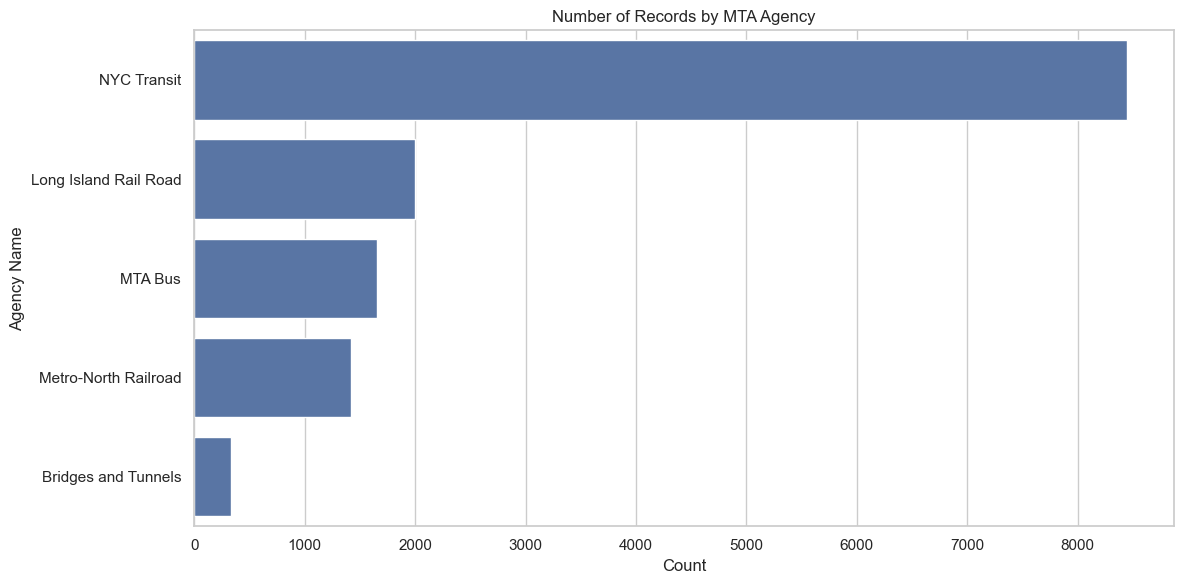

In [148]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='AGENCY_NAME', order=df['AGENCY_NAME'].value_counts().index)
plt.title('Number of Records by MTA Agency')
plt.xlabel('Count')
plt.ylabel('Agency Name')
plt.tight_layout()
plt.show()

# Top 15 Most Frequent Performance Indicators

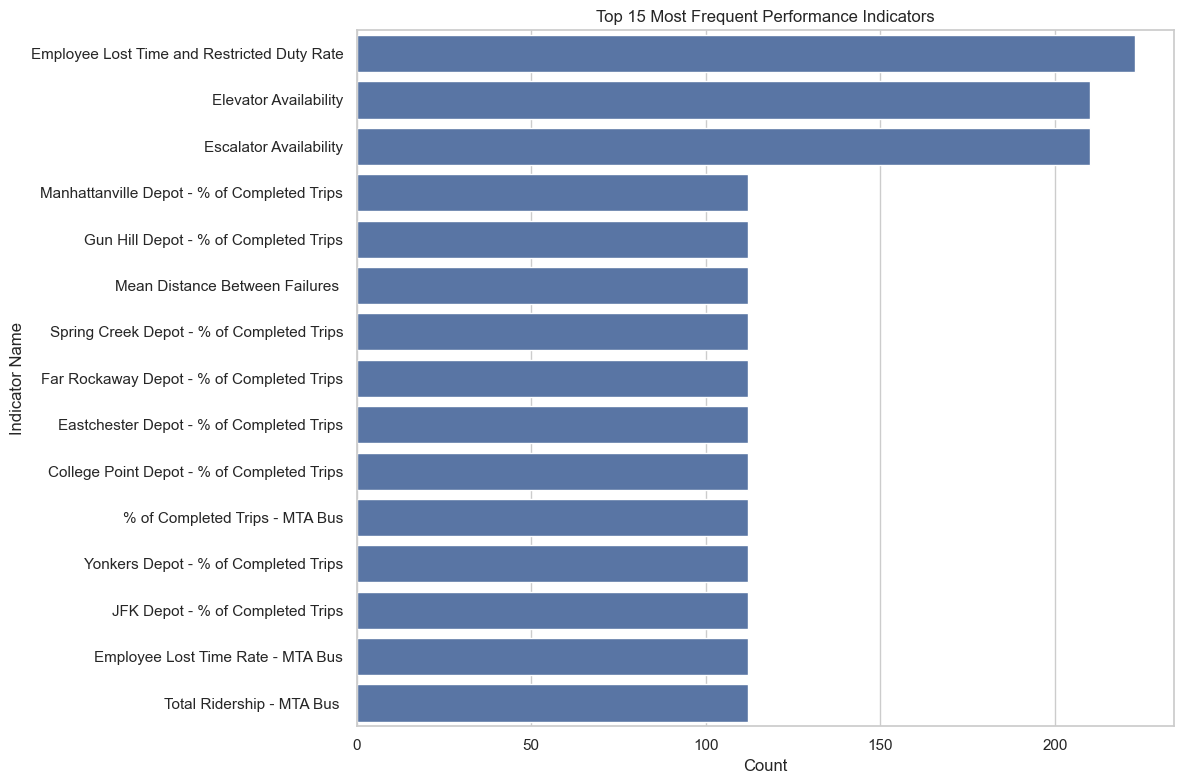

In [149]:
plt.figure(figsize=(12,8))
top_indicators = df['INDICATOR_NAME'].value_counts().nlargest(15).index
sns.countplot(data=df[df['INDICATOR_NAME'].isin(top_indicators)], y='INDICATOR_NAME', order=top_indicators)
plt.title('Top 15 Most Frequent Performance Indicators')
plt.xlabel('Count')
plt.ylabel('Indicator Name')
plt.tight_layout()
plt.show()

# Boxplot -  Comparing distributions across Agencies

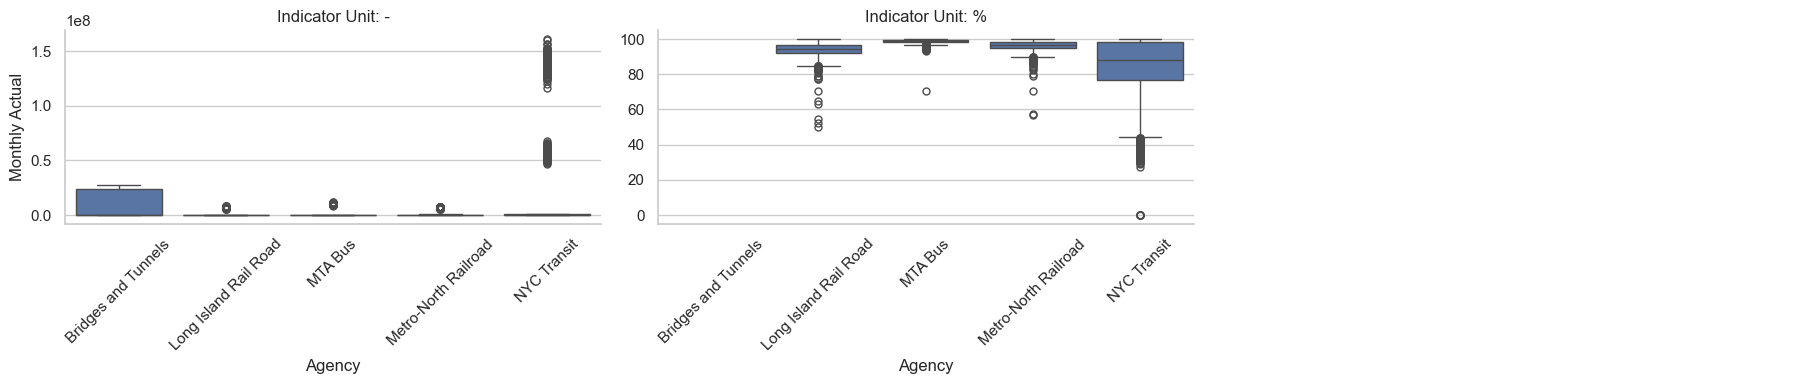

In [150]:
# Clean blank or missing indicator units for readability
df['INDICATOR_UNIT'] = df['INDICATOR_UNIT'].replace('', 'Unspecified')

# Create boxplots split by unit
g = sns.catplot(
    data=df,
    kind="box",
    x="AGENCY_NAME",
    y="MONTHLY_ACTUAL",
    col="INDICATOR_UNIT",
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

g.set_titles("Indicator Unit: {col_name}")
g.set_xticklabels(rotation=45)
g.set_xlabels("Agency")
g.set_ylabels("Monthly Actual")
plt.tight_layout()
plt.show()

# Barplot of All Agencies + Top 10 Indicators Per Agency

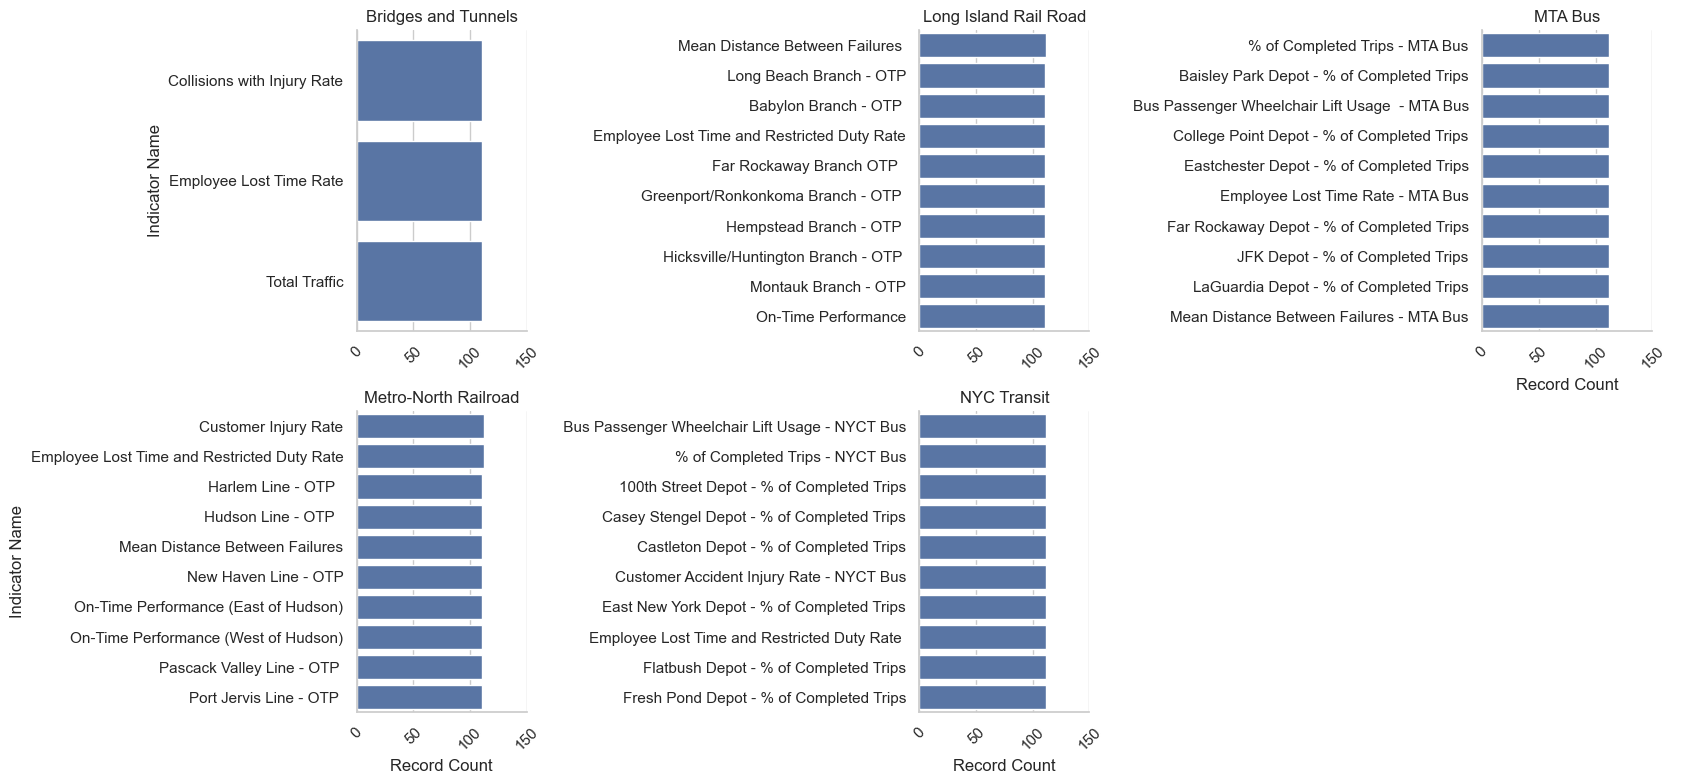

In [151]:
# Step 1: Count frequency of each indicator per agency
indicator_counts = df.groupby(['AGENCY_NAME', 'INDICATOR_NAME']).size().reset_index(name='Count')
# Step 2: Get top 5 indicators per agency
top5_per_agency = (
    indicator_counts.sort_values(['AGENCY_NAME', 'Count'], ascending=[True, False])
    .groupby('AGENCY_NAME')
    .head(10)
)
# Step 3: Faceted bar plot
g = sns.catplot(
    data=top5_per_agency,
    kind="bar",
    x="Count",
    y="INDICATOR_NAME",
    col="AGENCY_NAME",
    col_wrap=3,
    height=4,
    aspect=1.4,
    sharex=False,
    sharey=False
)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.set_ylabels("Indicator Name")
g.set_xlabels("Record Count")
plt.tight_layout()
plt.show()

# Correlation Matrix of Numerical Variables

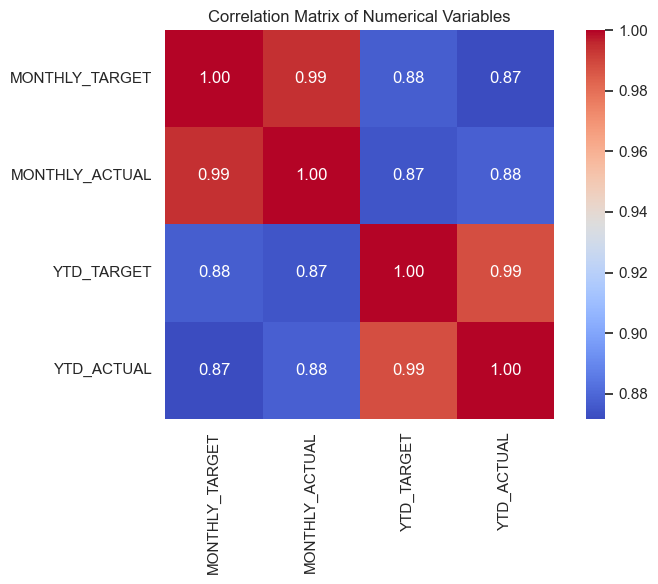

In [152]:
# Select only the numeric columns
numeric_cols = ['MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YTD_TARGET', 'YTD_ACTUAL']
df_numeric = df[numeric_cols]

# Calculate correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Faceted Boxplots Grouped by INDICATOR_UNIT

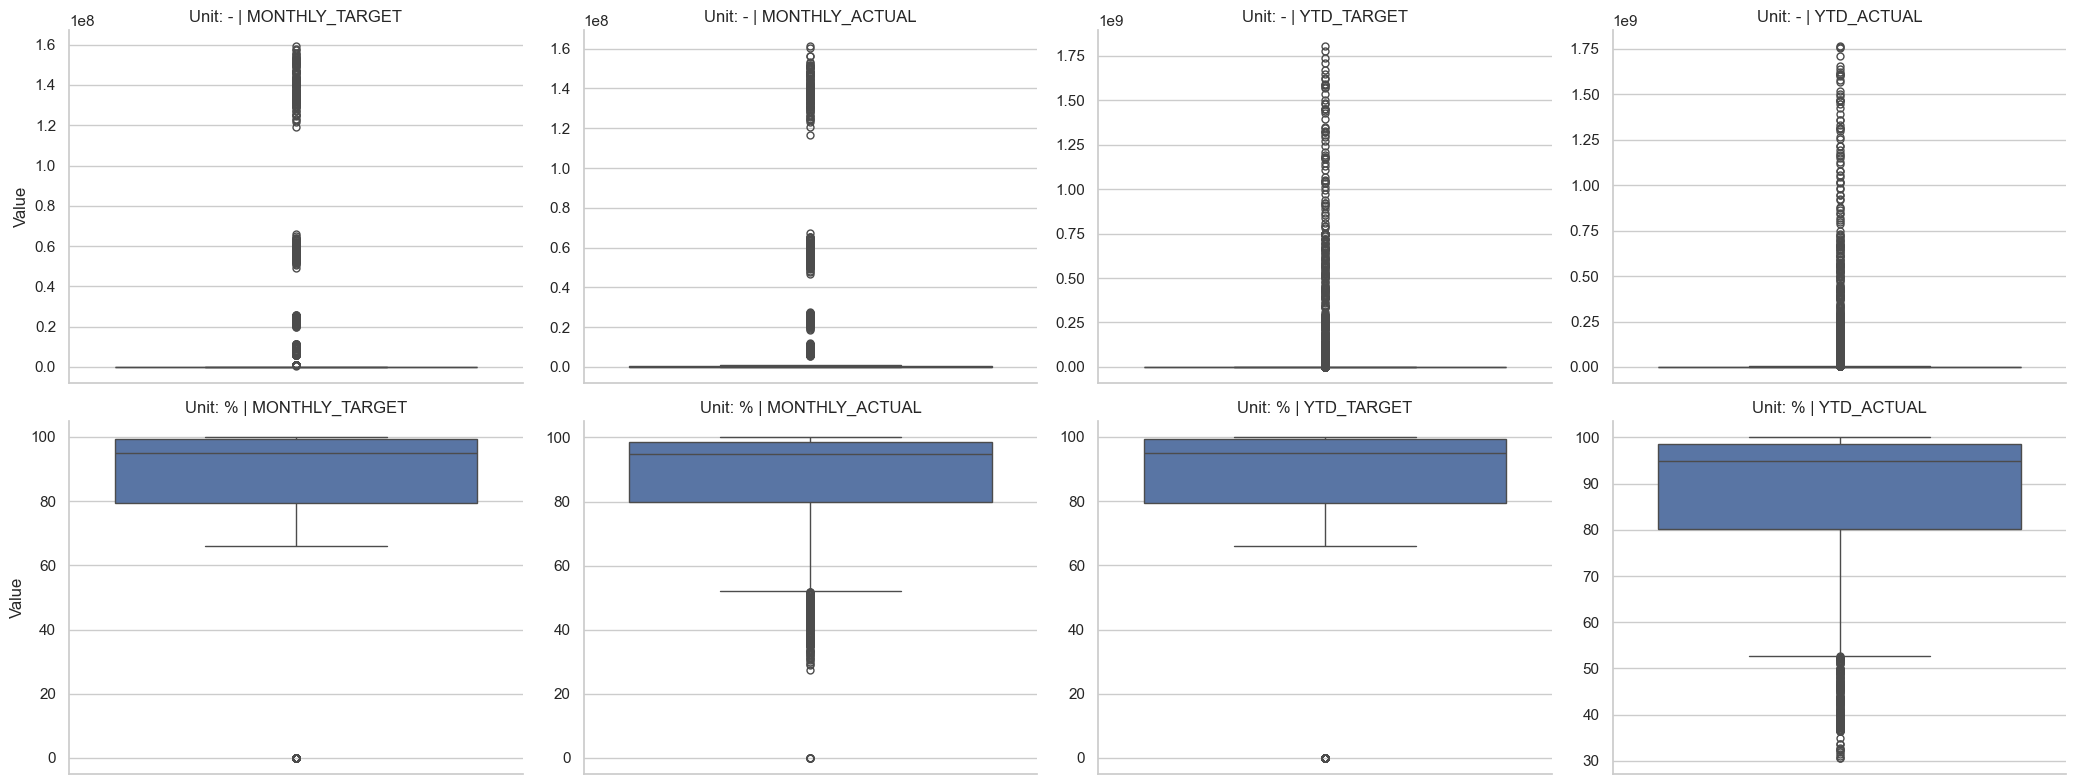

In [153]:
# Select numeric columns + unit column
numerical_cols = ['MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YTD_TARGET', 'YTD_ACTUAL']
melted_df = df[numerical_cols + ['INDICATOR_UNIT']].melt(
    id_vars='INDICATOR_UNIT',
    var_name='Metric',
    value_name='Value'
)

# Clean up blank units
melted_df['INDICATOR_UNIT'] = melted_df['INDICATOR_UNIT'].replace('', 'Unspecified')

# Create FacetGrid of boxplots (column = metric, row = indicator unit)
g = sns.catplot(
    data=melted_df,
    kind="box",
    y="Value",
    col="Metric",
    row="INDICATOR_UNIT",
    height=4,
    aspect=1.3,
    sharey=False
)

g.set_titles(col_template="{col_name}", row_template="Unit: {row_name}")
g.set_ylabels("Value")
plt.tight_layout()
plt.show()

## ----------- DATA PREPROCESSING STEPS -----------

In [154]:
import numpy as np

# Handling Zero Values


In [155]:
# Separate percentage and raw value indicators
percent_df = df[df['INDICATOR_UNIT'] == '%']
raw_df = df[df['INDICATOR_UNIT'] == '-']

# For percentage-based
zero_monthly_target_pct = (percent_df['MONTHLY_TARGET'] == 0).sum()
zero_ytd_target_pct = (percent_df['YTD_TARGET'] == 0).sum()
zero_either_pct = ((percent_df['MONTHLY_TARGET'] == 0) | (percent_df['YTD_TARGET'] == 0)).sum()
total_pct = len(percent_df)

# For raw-value-based
zero_monthly_target_raw = (raw_df['MONTHLY_TARGET'] == 0).sum()
zero_ytd_target_raw = (raw_df['YTD_TARGET'] == 0).sum()
zero_either_raw = ((raw_df['MONTHLY_TARGET'] == 0) | (raw_df['YTD_TARGET'] == 0)).sum()
total_raw = len(raw_df)

# Display results
print("=== Percentage-Based Indicators (%) ===")
print(f"Total rows: {total_pct}")
print(f"MONTHLY_TARGET = 0: {zero_monthly_target_pct}")
print(f"YTD_TARGET = 0: {zero_ytd_target_pct}")
print(f"Either target = 0: {zero_either_pct}")
print(f"Affected rows (%): {zero_either_pct / total_pct:.2%}")

print("\n=== Raw Value Indicators (-) ===")
print(f"Total rows: {total_raw}")
print(f"MONTHLY_TARGET = 0: {zero_monthly_target_raw}")
print(f"YTD_TARGET = 0: {zero_ytd_target_raw}")
print(f"Either target = 0: {zero_either_raw}")
print(f"Affected rows (%): {zero_either_raw / total_raw:.2%}")


=== Percentage-Based Indicators (%) ===
Total rows: 10769
MONTHLY_TARGET = 0: 817
YTD_TARGET = 0: 890
Either target = 0: 890
Affected rows (%): 8.26%

=== Raw Value Indicators (-) ===
Total rows: 3093
MONTHLY_TARGET = 0: 389
YTD_TARGET = 0: 389
Either target = 0: 389
Affected rows (%): 12.58%


Flagging the zero values for both (% and -) indicator_unit 

In [156]:
df['ZERO_TARGET_FLAG'] = (
    ((df['INDICATOR_UNIT'] == '%') | (df['INDICATOR_UNIT'] == '-')) &
    ((df['MONTHLY_TARGET'] == 0) | (df['YTD_TARGET'] == 0))
)

Imputing the zeros with median (% values) in MONTHLY_TARGET

In [157]:
# Calculate medians from % indicators where MONTHLY_TARGET is non-zero
percent_monthly_medians = (
    df[(df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['MONTHLY_TARGET']
    .median()
    .rename('PERCENT_MONTHLY_MEDIAN')
)

# Create imputed column
df['MONTHLY_TARGET_IMPUTED'] = df['MONTHLY_TARGET']

# Apply imputation to rows where target is 0
df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] == 0),
    'MONTHLY_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] == 0), 'INDICATOR_NAME'
].map(percent_monthly_medians)


In [158]:
# Preview rows that had 0 values and were imputed
preview_imputed_monthly = df[
    (df['INDICATOR_UNIT'] == '%') &
    (df['MONTHLY_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'MONTHLY_TARGET', 'MONTHLY_TARGET_IMPUTED']]

preview_imputed_monthly

,AGENCY_NAME,INDICATOR_NAME,MONTHLY_TARGET,MONTHLY_TARGET_IMPUTED
555,Long Island Rail Road,On-Time Performance,0.00,95.10
556,Long Island Rail Road,On-Time Performance,0.00,95.10
557,Long Island Rail Road,On-Time Performance,0.00,95.10
558,Long Island Rail Road,On-Time Performance,0.00,95.10
559,Long Island Rail Road,On-Time Performance,0.00,95.10
...,...,...,...,...
13771,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13772,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13773,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13783,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80


Imputing the zeros with median (% values) in YTD_TARGET

In [159]:
# Calculate medians from % indicators where YTD_TARGET is non-zero
percent_ytd_medians = (
    df[(df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['YTD_TARGET']
    .median()
    .rename('PERCENT_YTD_MEDIAN')
)

# Create imputed column
df['YTD_TARGET_IMPUTED'] = df['YTD_TARGET']

# Impute zero values using median
df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] == 0),
    'YTD_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] == 0), 'INDICATOR_NAME'
].map(percent_ytd_medians)


In [160]:
# Preview rows where YTD_TARGET was 0 and imputation has been applied
preview_imputed_ytd = df[
    (df['INDICATOR_UNIT'] == '%') &
    (df['YTD_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'YTD_TARGET', 'YTD_TARGET_IMPUTED']]

preview_imputed_ytd

,AGENCY_NAME,INDICATOR_NAME,YTD_TARGET,YTD_TARGET_IMPUTED
555,Long Island Rail Road,On-Time Performance,0.00,95.10
556,Long Island Rail Road,On-Time Performance,0.00,95.10
557,Long Island Rail Road,On-Time Performance,0.00,95.10
558,Long Island Rail Road,On-Time Performance,0.00,95.10
559,Long Island Rail Road,On-Time Performance,0.00,95.10
...,...,...,...,...
13783,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13785,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13812,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13820,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80


Imputing the zeros with median (- values) in YTD_TARGET

In [161]:
# Take YTD_TARGET medians only from raw-unit, non-zero rows
raw_medians = (
    df[(df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['YTD_TARGET']
    .median()
    .rename('RAW_YTD_IMPUTED_VALUE')
)

# Create column to hold imputed values
df['RAW_YTD_TARGET_IMPUTED'] = df['YTD_TARGET']

# Apply imputation only to rows with 0 values
df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] == 0),
    'RAW_YTD_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] == 0), 'INDICATOR_NAME'
].map(raw_medians)


In [162]:
# Preview rows where raw YTD_TARGET was 0 and has been imputed
preview_imputed_raw_ytd = df[
    (df['INDICATOR_UNIT'] == '-') &
    (df['YTD_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'YTD_TARGET', 'RAW_YTD_TARGET_IMPUTED']]

# Display first few rows
preview_imputed_raw_ytd


,AGENCY_NAME,INDICATOR_NAME,YTD_TARGET,RAW_YTD_TARGET_IMPUTED
84,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
85,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
86,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
87,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
88,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
...,...,...,...,...
9179,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9180,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9181,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9182,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"


Imputing the zeros with median (- values) in MONTHLY_TARGET

In [163]:
# Take MONTHLY_TARGET medians only from raw-unit, non-zero rows
monthly_raw_medians = (
    df[(df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['MONTHLY_TARGET']
    .median()
    .rename('RAW_MONTHLY_IMPUTED_VALUE')
)

# Create column to hold imputed values
df['RAW_MONTHLY_TARGET_IMPUTED'] = df['MONTHLY_TARGET']

# Apply imputation only to rows with 0 values
df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] == 0),
    'RAW_MONTHLY_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] == 0), 'INDICATOR_NAME'
].map(monthly_raw_medians)


In [164]:
# Preview rows where raw YTD_TARGET was 0 and has been imputed
preview_imputed_raw_monthly = df[
    (df['INDICATOR_UNIT'] == '-') &
    (df['MONTHLY_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'MONTHLY_TARGET', 'RAW_MONTHLY_TARGET_IMPUTED']]

preview_imputed_raw_monthly

,AGENCY_NAME,INDICATOR_NAME,MONTHLY_TARGET,RAW_MONTHLY_TARGET_IMPUTED
84,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
85,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
86,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
87,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
88,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
...,...,...,...,...
9179,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9180,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9181,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9182,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"


TEST

In [165]:
# For RAW YTD target
raw_ytd_summary = (
    df[df['INDICATOR_UNIT'] == '-']
    .groupby('INDICATOR_NAME')
    .agg(
        original_median=('YTD_TARGET', lambda x: x[x != 0].median()),
        imputed_value=('YTD_TARGET', lambda x: x[x != 0].median())  # NOT from the imputed column
    )
    .reset_index()
)

# View top rows
raw_ytd_summary


,INDICATOR_NAME,original_median,imputed_value
0,Bus Passenger Wheelchair Lift Usage - NYCT Bus,"665,039.00","665,039.00"
1,Bus Passenger Wheelchair Lift Usage - MTA Bus,"26,583.00","26,583.00"
2,Collisions with Injury Rate,0.85,0.85
3,Collisions with Injury Rate - MTA Bus,5.25,5.25
4,Collisions with Injury Rate - NYCT Bus,6.44,6.44
5,Customer Accident Injury Rate - MTA Bus,1.27,1.27
6,Customer Accident Injury Rate - NYCT Bus,1.11,1.11
7,Customer Injury Rate,2.80,2.80
8,Customer Injury Rate - Subways,3.00,3.00
9,Employee Lost Time Rate,4.10,4.10


# Removing Outliers

In [166]:
# Step 1: Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Step 2: Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  # log(1 + x) avoids log(0) issues

# Preview transformed data
df_raw[[col for col in df_raw.columns if col.startswith('LOG_')]]


,LOG_MONTHLY_ACTUAL,LOG_MONTHLY_TARGET,LOG_YTD_ACTUAL,LOG_YTD_TARGET
0,0.43,0.56,0.43,0.56
1,0.68,0.70,0.56,0.64
2,0.59,0.65,0.57,0.64
3,0.61,0.79,0.58,0.68
4,0.91,0.73,0.66,0.69
...,...,...,...,...
9243,11.67,11.72,14.22,14.19
9244,11.56,11.44,11.56,11.44
9245,11.50,11.38,12.22,12.11
9246,11.55,11.65,12.64,12.60


# Dropping low worth/variance columns

In [167]:
# Find columns with a single unique value
low_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
print("Low-variance columns:", low_variance_cols)


Low-variance columns: ['FREQUENCY']


In [168]:
# Dropping the low variance columns
df = df.drop(columns=low_variance_cols)
print(df.columns)

Index(['INDICATOR_SEQ', 'PARENT_SEQ', 'AGENCY_NAME', 'INDICATOR_NAME',
       'DESCRIPTION', 'CATEGORY', 'DESIRED_CHANGE', 'INDICATOR_UNIT',
       'DECIMAL_PLACES', 'PERIOD_YEAR', 'PERIOD_MONTH', 'YTD_TARGET',
       'YTD_ACTUAL', 'MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YYYY_MM', 'DATE',
       'ZERO_TARGET_FLAG', 'MONTHLY_TARGET_IMPUTED', 'YTD_TARGET_IMPUTED',
       'RAW_YTD_TARGET_IMPUTED', 'RAW_MONTHLY_TARGET_IMPUTED'],
      dtype='object')


# EDA 2nd round


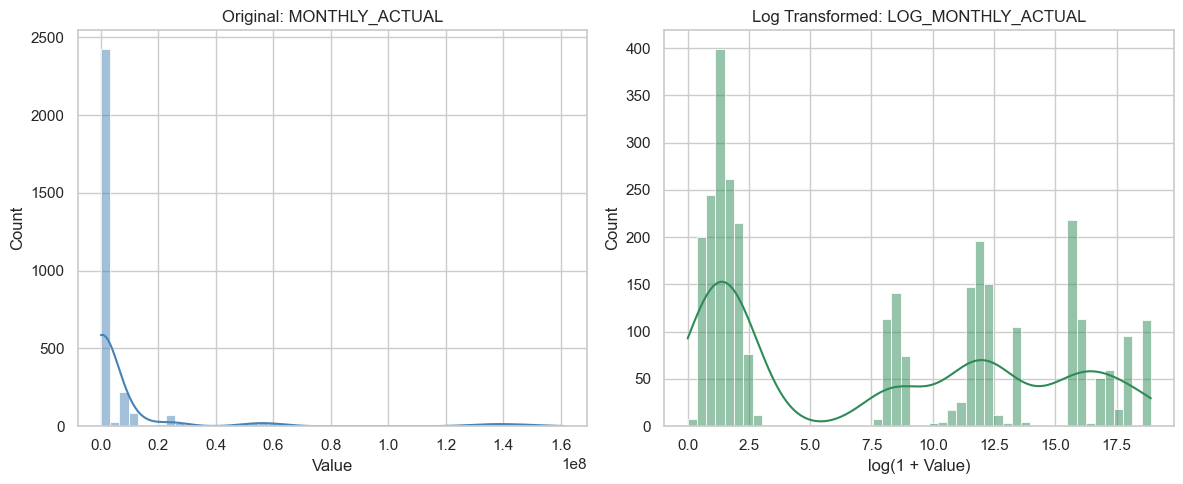

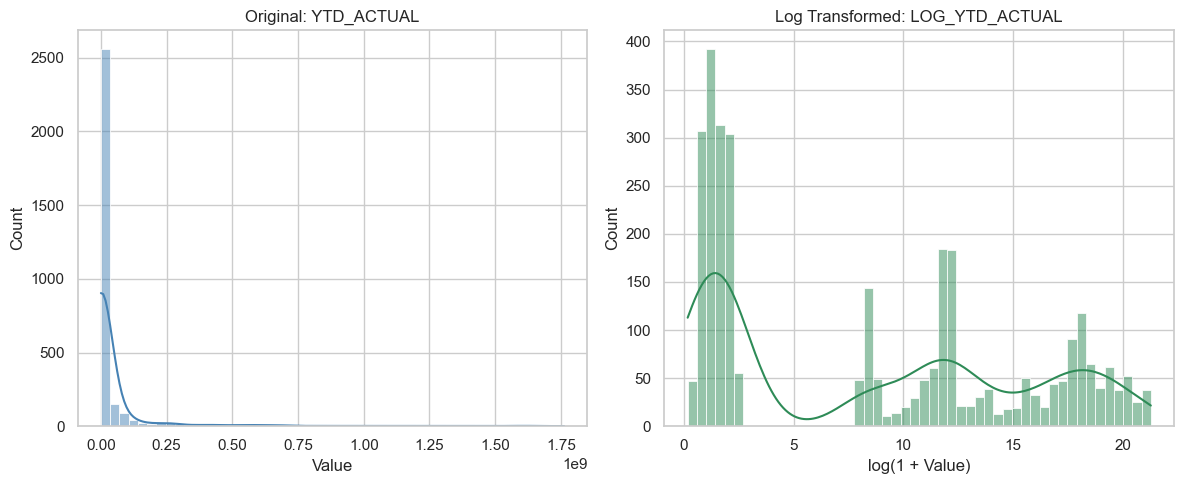

In [169]:
# List of original columns and their log-transformed counterparts
numeric_cols = ['MONTHLY_ACTUAL', 'YTD_ACTUAL', 'RAW_MONTHLY_TARGET_IMPUTED', 'RAW_YTD_TARGET_IMPUTED']

for col in numeric_cols:
    log_col = f'LOG_{col}'
    
    # Check if log-transformed column exists to avoid errors
    if log_col in df_raw.columns:
        plt.figure(figsize=(12, 5))
        
        # Original
        plt.subplot(1, 2, 1)
        sns.histplot(df_raw[col], bins=50, kde=True, color='steelblue')
        plt.title(f'Original: {col}')
        plt.xlabel('Value')
        
        # Log-transformed
        plt.subplot(1, 2, 2)
        sns.histplot(df_raw[log_col], bins=50, kde=True, color='seagreen')
        plt.title(f'Log Transformed: {log_col}')
        plt.xlabel('log(1 + Value)')
        
        plt.tight_layout()
        plt.show()

   LOG_MONTHLY_ACTUAL  LOG_MONTHLY_TARGET  LOG_YTD_ACTUAL  LOG_YTD_TARGET
0                0.43                0.56            0.43            0.56
1                0.68                0.70            0.56            0.64
2                0.59                0.65            0.57            0.64
3                0.61                0.79            0.58            0.68
4                0.91                0.73            0.66            0.69


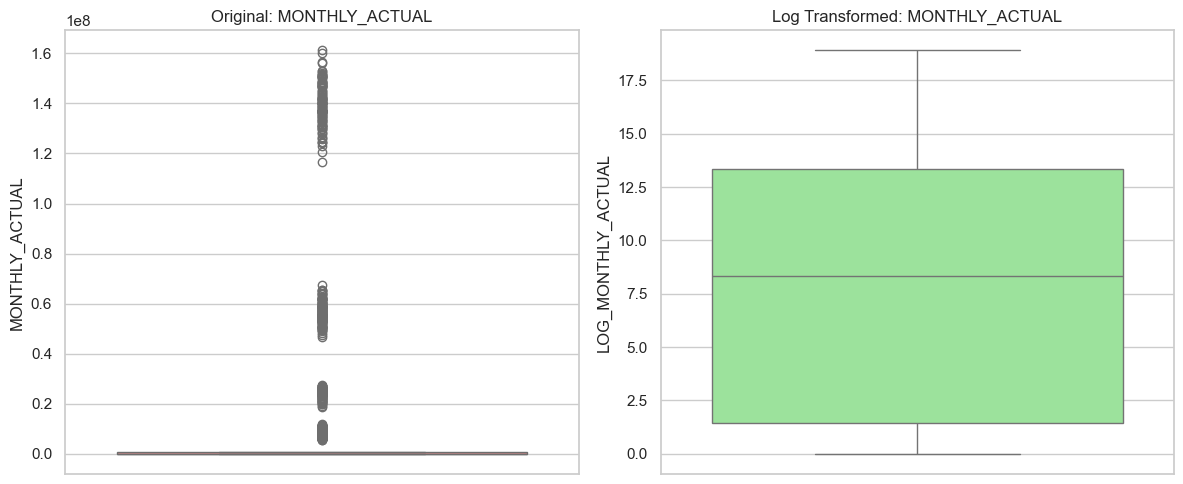

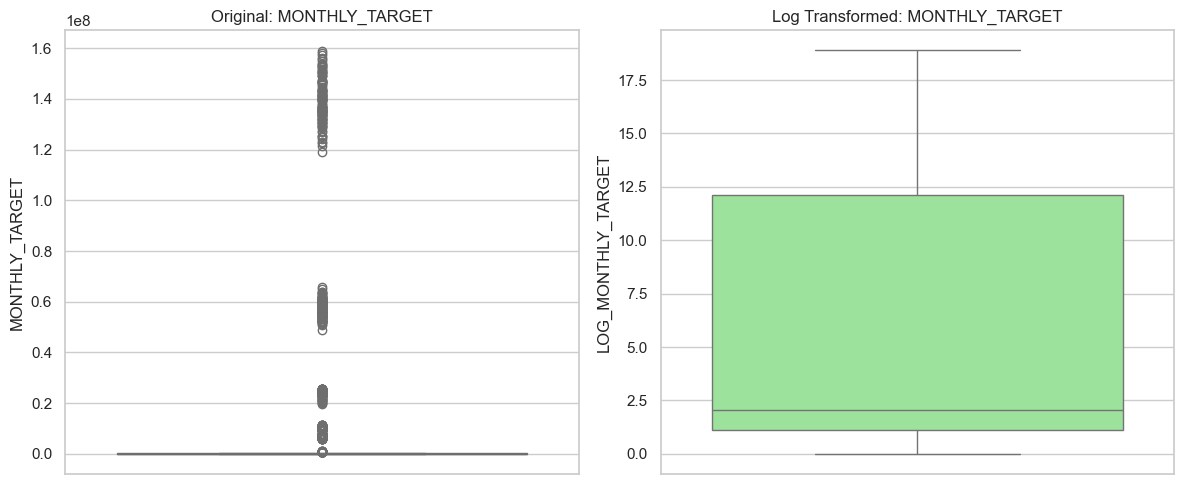

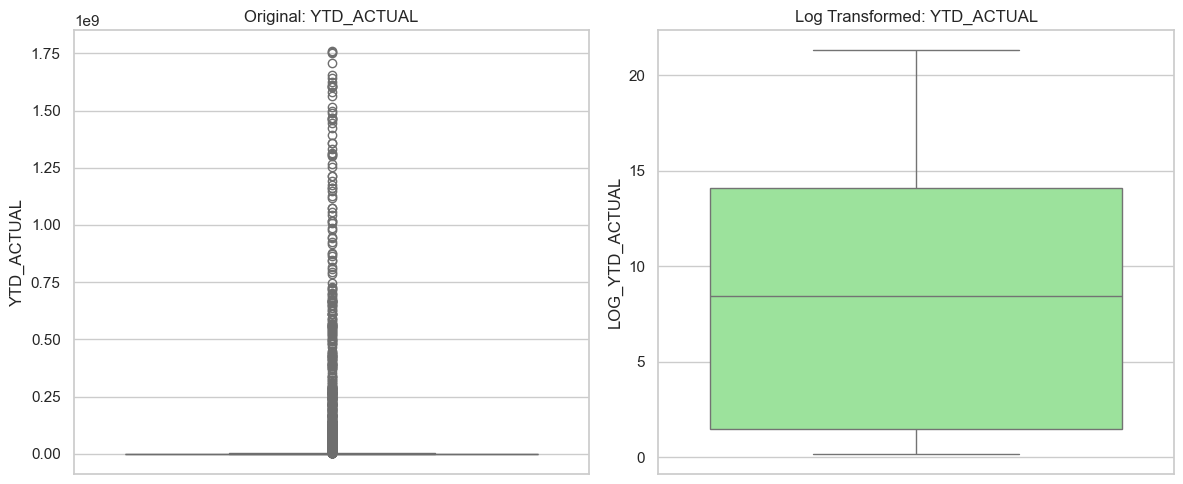

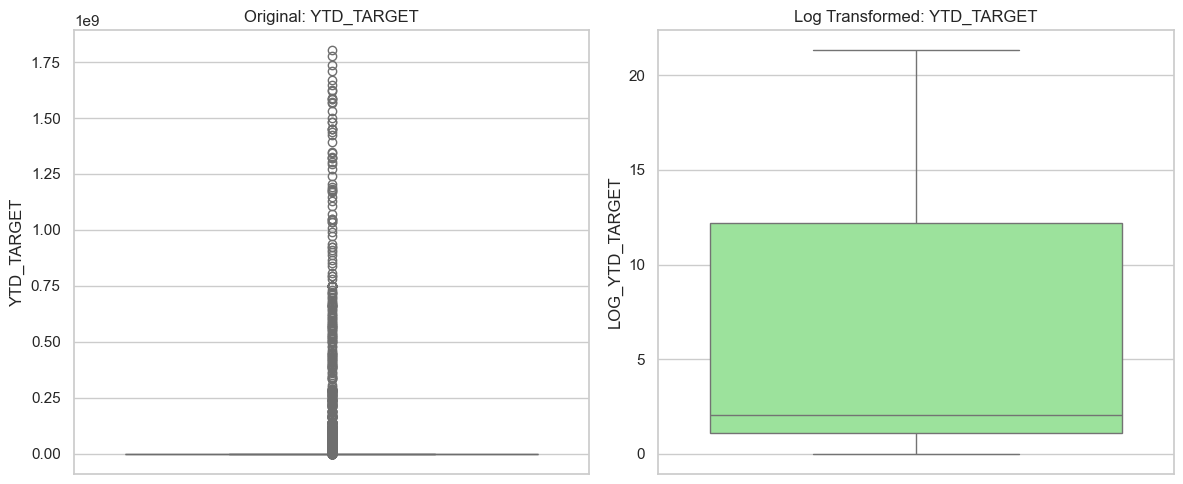

In [170]:
# Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  

# Preview transformed data
print(df_raw[[col for col in df_raw.columns if col.startswith('LOG_')]].head())

# Visualize before and after log transformation
for original_col in numeric_cols:
    log_col = f'LOG_{original_col}'
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_raw[original_col], color='lightcoral')
    plt.title(f'Original: {original_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_raw[log_col], color='lightgreen')
    plt.title(f'Log Transformed: {original_col}')

    plt.tight_layout()
    plt.show()

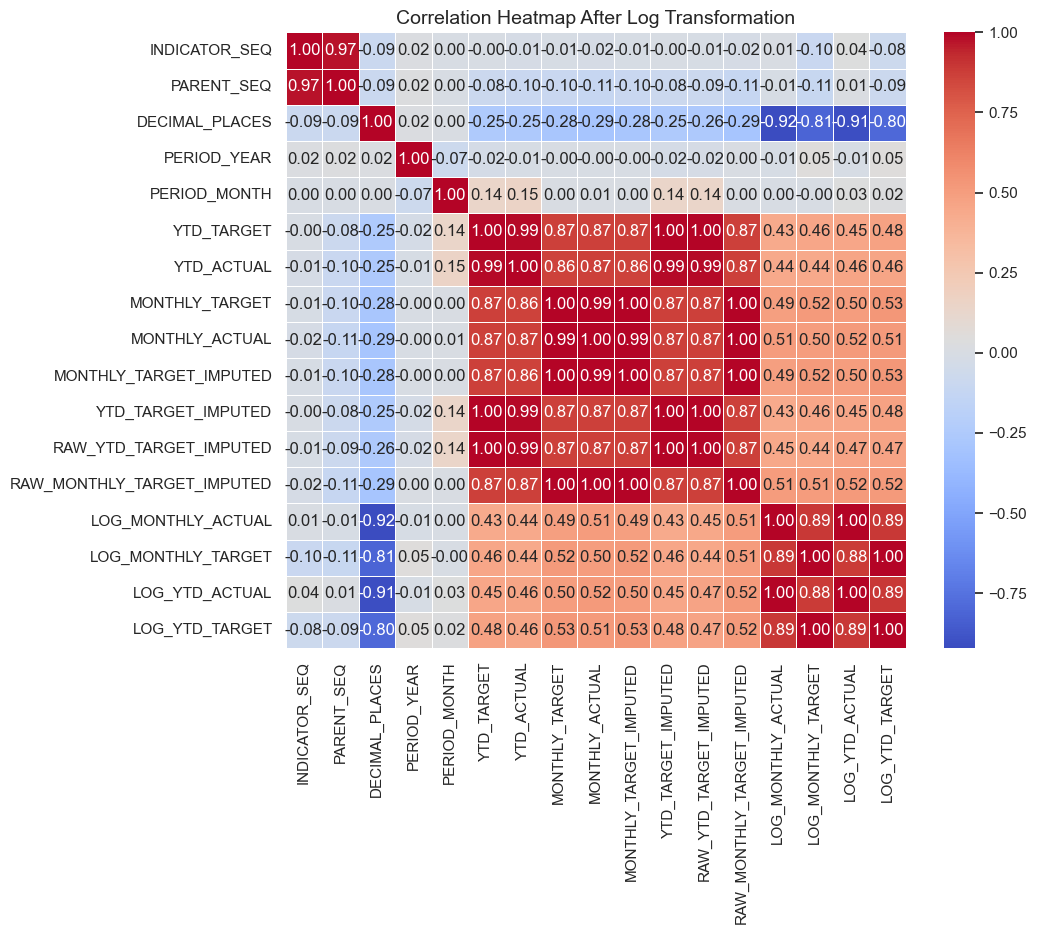

In [171]:
# Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  # log(1 + x) avoids log(0) issues

# Calculate the correlation matrix for numerical columns in df_raw
corr = df_raw.select_dtypes(include=np.number).corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap After Log Transformation", fontsize=14)
plt.show()

# Temporal Patterns Analysis

Dataset Time Range:
Start: 2008-01-01 00:00:00
End: 2017-04-01 00:00:00
Total months: 112


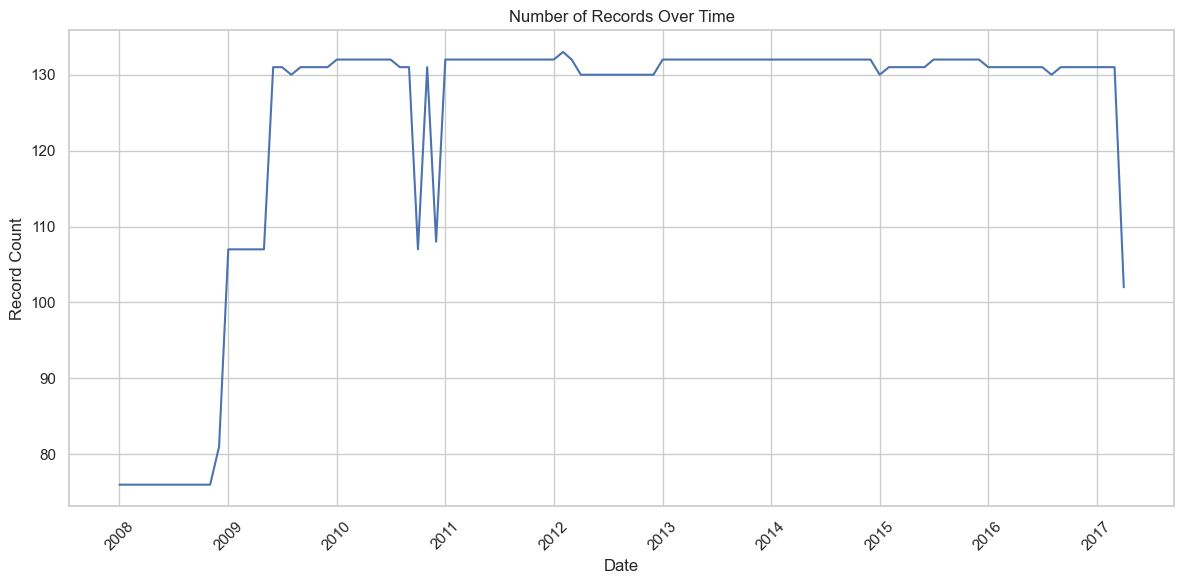

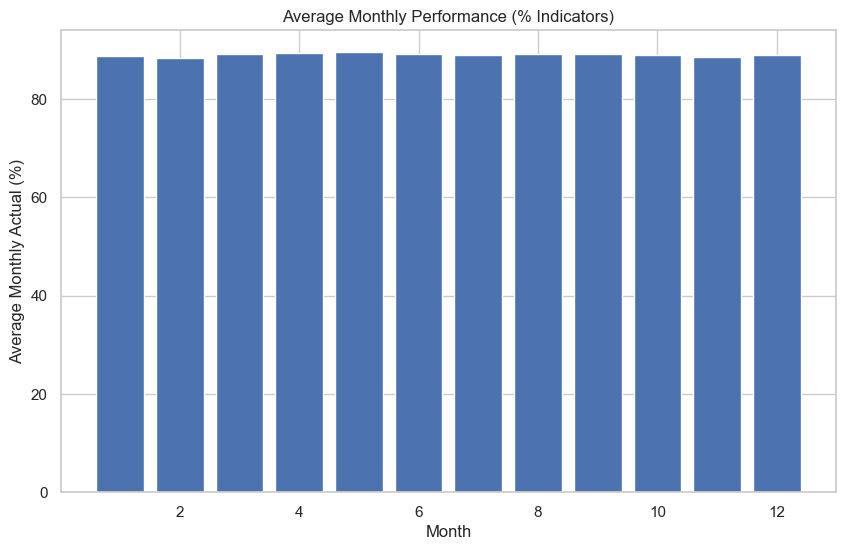

In [172]:
# Analyze temporal patterns in the data
print("Dataset Time Range:")
print(f"Start: {df['DATE'].min()}")
print(f"End: {df['DATE'].max()}")
print(f"Total months: {df['DATE'].nunique()}")

# Check data distribution over time
plt.figure(figsize=(12, 6))
monthly_counts = df.groupby('DATE').size()
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Number of Records Over Time')
plt.xlabel('Date')
plt.ylabel('Record Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for seasonality in performance metrics
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# Sample seasonal analysis for percentage indicators
pct_data = df[df['INDICATOR_UNIT'] == '%']
seasonal_perf = pct_data.groupby('Month')['MONTHLY_ACTUAL'].mean()

plt.figure(figsize=(10, 6))
plt.bar(seasonal_perf.index, seasonal_perf.values)
plt.title('Average Monthly Performance (% Indicators)')
plt.xlabel('Month')
plt.ylabel('Average Monthly Actual (%)')
plt.show()

# March 2017 Cutoff
Implement uniform cutoff at **March 31, 2017** to ensure:
- Fair model evaluation across all agencies
- Consistent forecasting horizon for performance comparison

In [173]:
# Analyze data coverage by agency
agency_coverage = df.groupby('AGENCY_NAME')['DATE'].agg(['min', 'max', 'count']).reset_index()
agency_coverage['date_range_months'] = (
    (agency_coverage['max'] - agency_coverage['min']).dt.days / 30.44
).round(1)

# Sort by end date to show inconsistency
agency_coverage = agency_coverage.sort_values('max', ascending=False)

print("Data Coverage by Agency:")
print(f"{'Agency':<30} {'Start':<12} {'End':<12} {'Records':<8} {'Range (months)'}")
print("-" * 70)

for _, row in agency_coverage.iterrows():
    agency_name = row['AGENCY_NAME'][:28] + '..' if len(row['AGENCY_NAME']) > 30 else row['AGENCY_NAME']
    print(f"{agency_name:<30} {row['min'].strftime('%Y-%m'):<12} {row['max'].strftime('%Y-%m'):<12} {row['count']:<8} {row['date_range_months']}")

print(f"\n")
print(f"• Earliest start: {agency_coverage['min'].min().strftime('%Y-%m')}")
print(f"• Latest end: {agency_coverage['max'].max().strftime('%Y-%m')}")  
print(f"• Most common end period: Around {pd.to_datetime('2017-03').strftime('%Y-%m')}")
print(f"• Range of end dates: {(agency_coverage['max'].max() - agency_coverage['max'].min()).days / 365.25:.1f} years")

Data Coverage by Agency:
Agency                         Start        End          Records  Range (months)
----------------------------------------------------------------------
Long Island Rail Road          2008-01      2017-04      1997     111.0
MTA Bus                        2008-01      2017-04      1658     111.0
Metro-North Railroad           2008-01      2017-04      1423     111.0
NYC Transit                    2008-01      2017-04      8451     111.0
Bridges and Tunnels            2008-01      2017-03      333      110.0


• Earliest start: 2008-01
• Latest end: 2017-04
• Most common end period: Around 2017-03
• Range of end dates: 0.1 years


In [174]:
# CUTOFF IMPACT ANALYSIS
# Define cutoff date
cutoff_date = pd.Timestamp('2017-03-31')

# Calculate impact statistics
total_records_before = len(df)
records_after_cutoff = len(df[df['DATE'] > cutoff_date])
records_kept = total_records_before - records_after_cutoff
removal_percentage = (records_after_cutoff / total_records_before) * 100

print(f"OVERALL IMPACT:")
print(f"• Total records before cutoff: {total_records_before:,}")
print(f"• Records removed (after March 2017): {records_after_cutoff:,}")
print(f"• Records kept (≤ March 2017): {records_kept:,}")
print(f"• Percentage removed: {removal_percentage:.2f}%")
print(f"• Data retention rate: {100-removal_percentage:.2f}%")

# Agency-specific impact
print(f"\n")
agency_impact = []

for agency in df['AGENCY_NAME'].unique():
    agency_data = df[df['AGENCY_NAME'] == agency]
    total_agency_records = len(agency_data)
    agency_removed = len(agency_data[agency_data['DATE'] > cutoff_date])
    agency_kept = total_agency_records - agency_removed
    agency_removal_pct = (agency_removed / total_agency_records) * 100 if total_agency_records > 0 else 0
    
    agency_impact.append({
        'Agency': agency,
        'Total_Records': total_agency_records,
        'Removed': agency_removed,
        'Kept': agency_kept,
        'Removal_Pct': agency_removal_pct
    })

agency_impact_df = pd.DataFrame(agency_impact).sort_values('Removal_Pct', ascending=False)

print(f"{'Agency':<30} {'Total':<7} {'Removed':<8} {'Kept':<7} {'% Removed'}")
print("-" * 65)
for _, row in agency_impact_df.head(10).iterrows():  # Show top 10 most impacted
    agency_name = row['Agency'][:28] + '..' if len(row['Agency']) > 30 else row['Agency']
    print(f"{agency_name:<30} {row['Total_Records']:<7} {row['Removed']:<8} {row['Kept']:<7} {row['Removal_Pct']:.1f}%")


OVERALL IMPACT:
• Total records before cutoff: 13,862
• Records removed (after March 2017): 102
• Records kept (≤ March 2017): 13,760
• Percentage removed: 0.74%
• Data retention rate: 99.26%


Agency                         Total   Removed  Kept    % Removed
-----------------------------------------------------------------
NYC Transit                    8451    81       8370    1.0%
MTA Bus                        1658    15       1643    0.9%
Metro-North Railroad           1423    5        1418    0.4%
Long Island Rail Road          1997    1        1996    0.1%
Bridges and Tunnels            333     0        333     0.0%


Creating temporal coverage visualization...


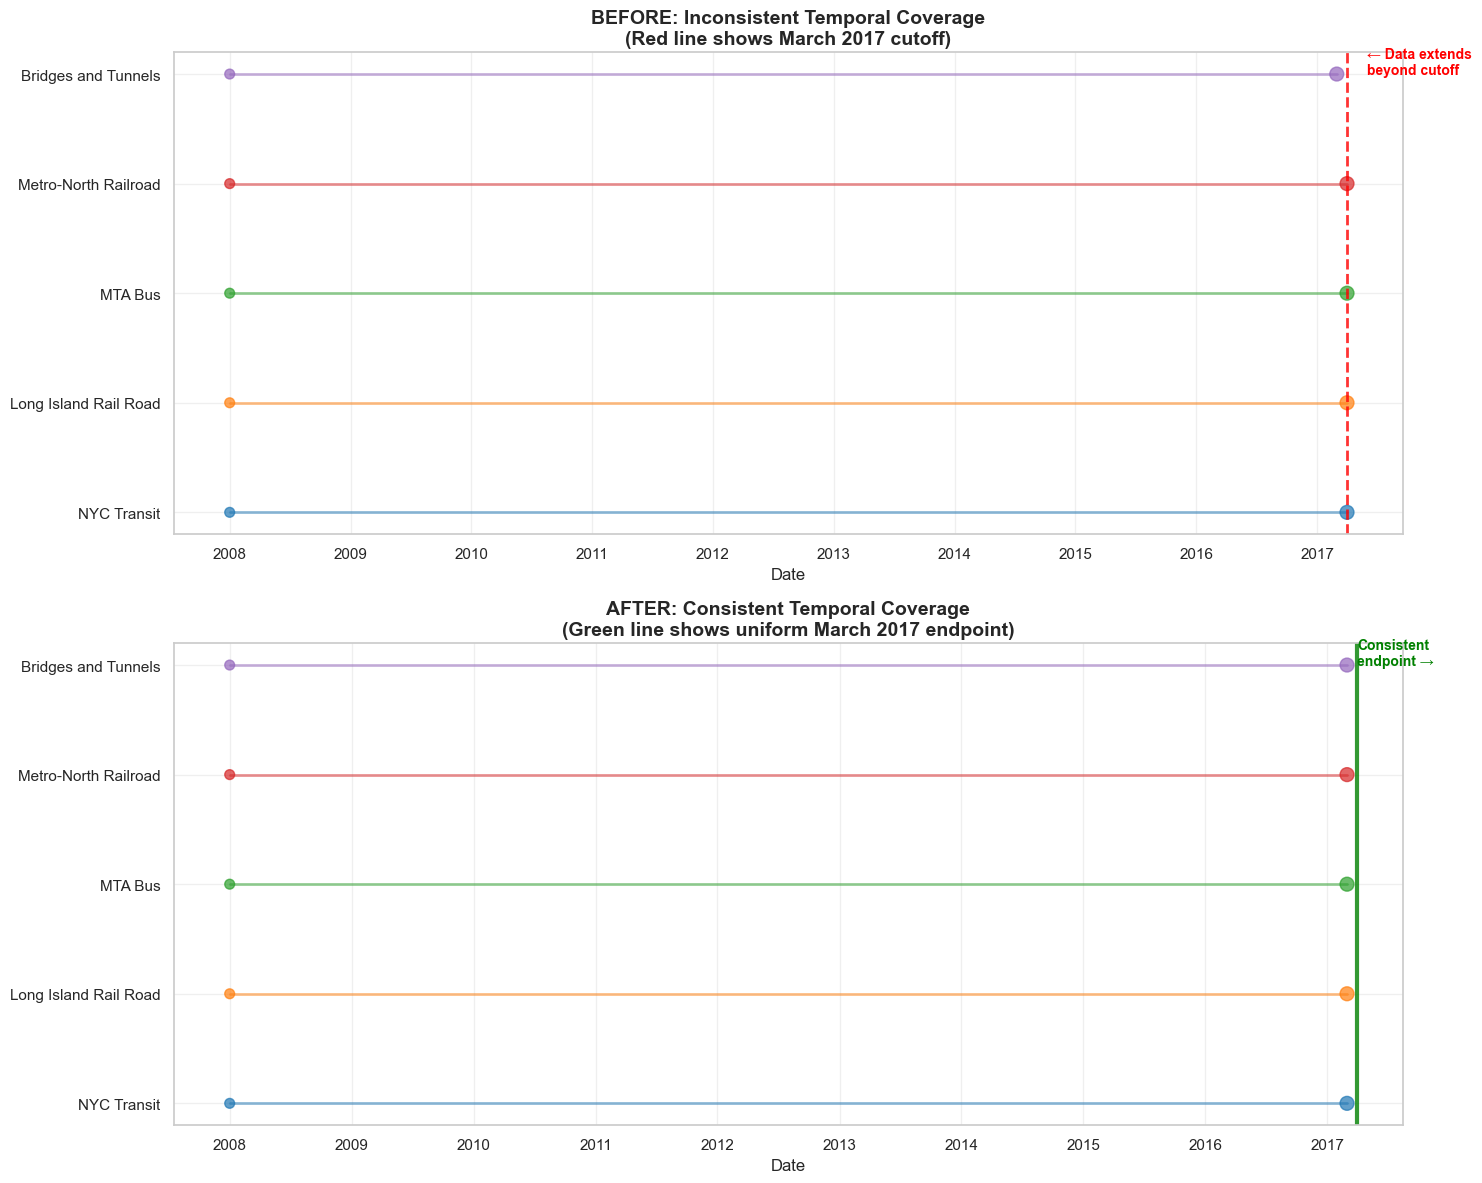

In [175]:
# VISUALIZATION: Before/After Temporal Coverage
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Before cutoff - Full temporal coverage
print("Creating temporal coverage visualization...")

# Sample agencies for visualization (top 10 by record count to avoid overcrowding)
top_agencies = df.groupby('AGENCY_NAME').size().nlargest(10).index
sample_df = df[df['AGENCY_NAME'].isin(top_agencies)]

# Plot 1: Full coverage (before cutoff)
for i, agency in enumerate(top_agencies):
    agency_dates = sample_df[sample_df['AGENCY_NAME'] == agency]['DATE']
    if len(agency_dates) > 0:
        ax1.scatter([agency_dates.min(), agency_dates.max()], [i, i], 
                   s=[50, 100], alpha=0.7, color=plt.cm.tab10(i))
        ax1.plot([agency_dates.min(), agency_dates.max()], [i, i], 
                alpha=0.5, linewidth=2, color=plt.cm.tab10(i))

ax1.axvline(pd.Timestamp('2017-03-31'), color='red', linestyle='--', linewidth=2, alpha=0.8)
ax1.set_yticks(range(len(top_agencies)))
ax1.set_yticklabels([agency[:25] + '...' if len(agency) > 25 else agency for agency in top_agencies])
ax1.set_title('BEFORE: Inconsistent Temporal Coverage\n(Red line shows March 2017 cutoff)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.grid(True, alpha=0.3)
ax1.text(pd.Timestamp('2017-06-01'), len(top_agencies)*0.8, '← Data extends\nbeyond cutoff', 
         color='red', fontweight='bold', fontsize=10)

# Plot 2: After cutoff - Consistent coverage
cutoff_date = pd.Timestamp('2017-03-31')
sample_df_after = sample_df[sample_df['DATE'] <= cutoff_date]

for i, agency in enumerate(top_agencies):
    agency_dates = sample_df_after[sample_df_after['AGENCY_NAME'] == agency]['DATE']
    if len(agency_dates) > 0:
        ax2.scatter([agency_dates.min(), agency_dates.max()], [i, i], 
                   s=[50, 100], alpha=0.7, color=plt.cm.tab10(i))
        ax2.plot([agency_dates.min(), agency_dates.max()], [i, i], 
                alpha=0.5, linewidth=2, color=plt.cm.tab10(i))

ax2.axvline(pd.Timestamp('2017-03-31'), color='green', linestyle='-', linewidth=3, alpha=0.8)
ax2.set_yticks(range(len(top_agencies)))
ax2.set_yticklabels([agency[:25] + '...' if len(agency) > 25 else agency for agency in top_agencies])
ax2.set_title('AFTER: Consistent Temporal Coverage\n(Green line shows uniform March 2017 endpoint)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.text(pd.Timestamp('2017-04-01'), len(top_agencies)*0.8, 'Consistent\nendpoint →', 
         color='green', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Hypothesis 1: Many Key Performance Indicators (KPIs) show month-of-year seasonality

In [176]:
from scipy.stats import kruskal
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

In [177]:
df["Month"] = df["DATE"].dt.month
def seasonality_test(g):
    groups = [x["MONTHLY_ACTUAL"].dropna().values for _, x in g.groupby("Month")]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) >= 3:
        stat, p = kruskal(*groups)
        return pd.Series({"KW_p": p})
    return pd.Series({"KW_p": np.nan})

seasonal = (df.groupby(["AGENCY_NAME","INDICATOR_NAME"])
              .apply(seasonality_test).reset_index())
seasonal["Seasonal_flag"] = seasonal["KW_p"] < 0.05
seasonality_share = seasonal["Seasonal_flag"].mean()
print(f'Share of series with seasonality: {seasonality_share:.2%}')


Share of series with seasonality: 16.54%


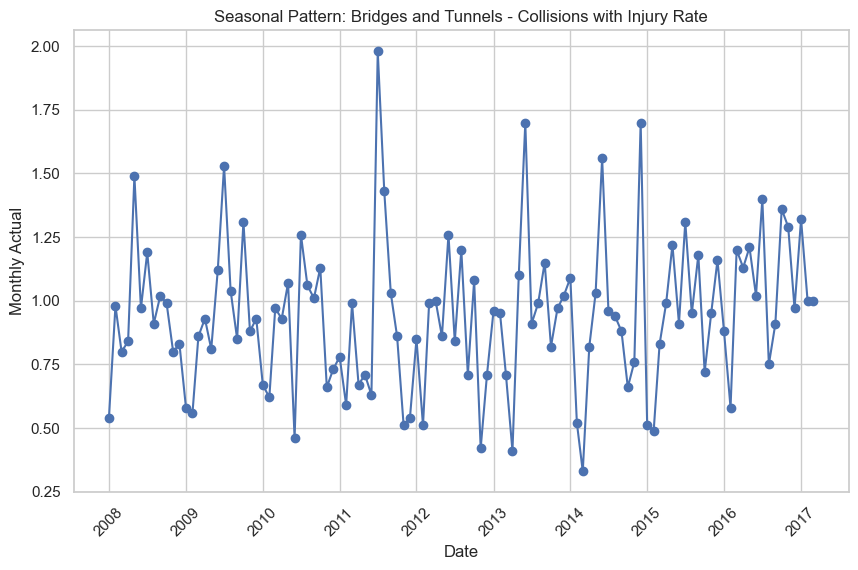

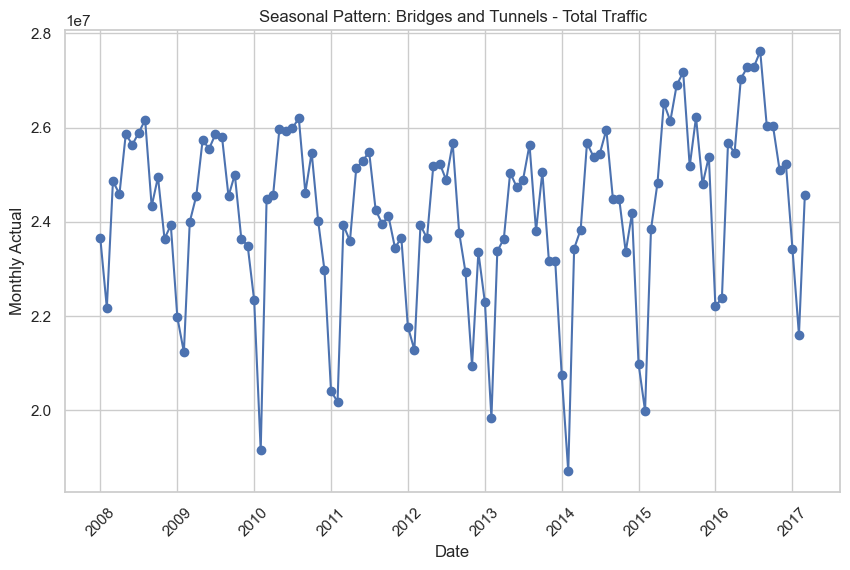

In [178]:

# Example charts for 1-2 series with seasonality
import matplotlib.pyplot as plt

# Select series with seasonality
seasonal_series = seasonal[seasonal["Seasonal_flag"] == True].head(2)

for idx, row in seasonal_series.iterrows():
    agency = row["AGENCY_NAME"]
    indicator = row["INDICATOR_NAME"]
    series_data = df[(df["AGENCY_NAME"] == agency) & (df["INDICATOR_NAME"] == indicator)].sort_values("DATE")
    plt.figure(figsize=(10, 6))
    plt.plot(series_data["DATE"], series_data["MONTHLY_ACTUAL"], marker='o')
    plt.title(f'Seasonal Pattern: {agency} - {indicator}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Actual')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


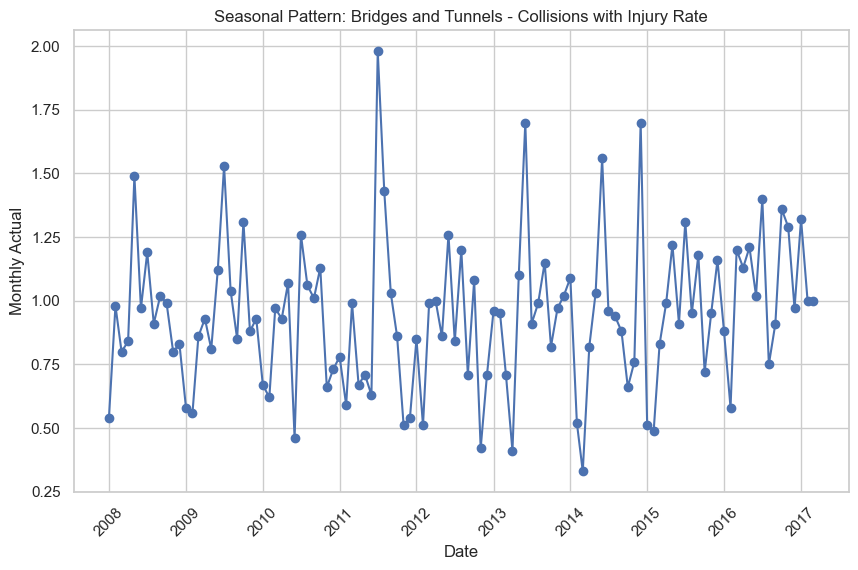

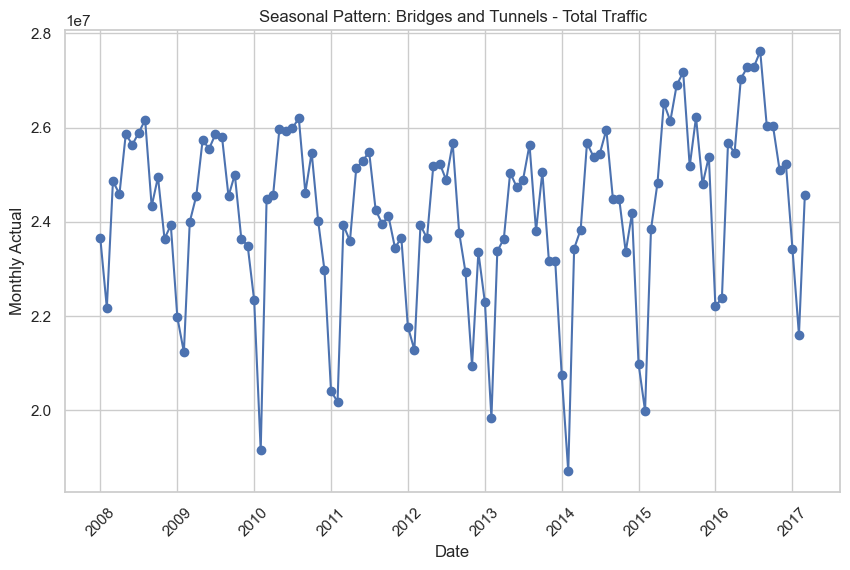

In [179]:
# Select series with seasonality
seasonal_series = seasonal[seasonal["Seasonal_flag"] == True].head(2)

for idx, row in seasonal_series.iterrows():
    agency = row["AGENCY_NAME"]
    indicator = row["INDICATOR_NAME"]
    series_data = df[(df["AGENCY_NAME"] == agency) & (df["INDICATOR_NAME"] == indicator)].sort_values("DATE")
    plt.figure(figsize=(10, 6))
    plt.plot(series_data["DATE"], series_data["MONTHLY_ACTUAL"], marker='o')
    plt.title(f'Seasonal Pattern: {agency} - {indicator}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Actual')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

## Hypothesis 2: Targets are sometimes "unset" (zeros) and this pattern is not random across agencies - certain agencies may have systematically higher rates of missing/zero targets.

In [180]:
# Chi-square test of independence between zero-target flag and AGENCY_NAME
from scipy.stats import chi2_contingency

print("=== ZERO TARGET DISTRIBUTION ANALYSIS ===\n")

# Create zero target flag
df["zero_tgt"] = (df["MONTHLY_TARGET"].fillna(0) == 0).astype(int)

# Overall zero target rate
total_records = len(df)
zero_targets = df["zero_tgt"].sum()
overall_zero_rate = (zero_targets / total_records) * 100

print(f"📊 OVERALL ZERO TARGET STATISTICS:")
print(f"• Total records: {total_records:,}")
print(f"• Zero targets: {zero_targets:,}")
print(f"• Overall zero target rate: {overall_zero_rate:.2f}%")

# Create contingency table
ct = pd.crosstab(df["AGENCY_NAME"], df["zero_tgt"], margins=True)
print(f"\n📋 CONTINGENCY TABLE:")
print("(Rows: Agencies, Columns: 0=Non-zero Target, 1=Zero Target)")
print(ct)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(ct.iloc[:-1, :-1])  # Exclude margins

print(f"\n🧪 CHI-SQUARE TEST RESULTS:")
print(f"• Chi-square statistic: {chi2:.4f}")
print(f"• p-value: {p:.6f}")
print(f"• Degrees of freedom: {dof}")
print(f"• Critical value (α=0.05): {chi2:.4f}")

# Interpretation
if p < 0.05:
    print(f"✅ SIGNIFICANT RESULT (p < 0.05)")
    print(f"• Zero-target patterns are NOT randomly distributed across agencies")
    print(f"• Some agencies have systematically different zero-target rates")
else:
    print(f"❌ NON-SIGNIFICANT RESULT (p ≥ 0.05)")
    print(f"• Zero-target patterns appear randomly distributed across agencies")
    print(f"• No evidence of systematic agency-specific patterns")

=== ZERO TARGET DISTRIBUTION ANALYSIS ===

📊 OVERALL ZERO TARGET STATISTICS:
• Total records: 13,862
• Zero targets: 1,206
• Overall zero target rate: 8.70%

📋 CONTINGENCY TABLE:
(Rows: Agencies, Columns: 0=Non-zero Target, 1=Zero Target)
zero_tgt                   0     1    All
AGENCY_NAME                              
Bridges and Tunnels      243    90    333
Long Island Rail Road   1709   288   1997
MTA Bus                 1548   110   1658
Metro-North Railroad    1399    24   1423
NYC Transit             7757   694   8451
All                    12656  1206  13862

🧪 CHI-SQUARE TEST RESULTS:
• Chi-square statistic: 322.6740
• p-value: 0.000000
• Degrees of freedom: 4
• Critical value (α=0.05): 322.6740
✅ SIGNIFICANT RESULT (p < 0.05)
• Zero-target patterns are NOT randomly distributed across agencies
• Some agencies have systematically different zero-target rates


In [181]:
# DETAILED AGENCY-SPECIFIC ZERO TARGET ANALYSIS
print(f"\n📈 AGENCY-SPECIFIC ZERO TARGET RATES:")

# Calculate zero target rates by agency
agency_zero_rates = df.groupby('AGENCY_NAME').agg({
    'zero_tgt': ['sum', 'count', 'mean']
}).round(4)

agency_zero_rates.columns = ['Zero_Targets', 'Total_Records', 'Zero_Rate']
agency_zero_rates['Zero_Rate_Pct'] = agency_zero_rates['Zero_Rate'] * 100
agency_zero_rates = agency_zero_rates.sort_values('Zero_Rate_Pct', ascending=False)

print(f"{'Agency':<35} {'Zero Targets':<12} {'Total':<8} {'Zero Rate'}")
print("-" * 70)

for agency, row in agency_zero_rates.iterrows():
    agency_short = agency[:33] + '..' if len(agency) > 35 else agency
    zero_count = int(row['Zero_Targets'])
    total_count = int(row['Total_Records'])
    zero_rate = row['Zero_Rate_Pct']
    
    print(f"{agency_short:<35} {zero_count:<12} {total_count:<8} {zero_rate:.2f}%")

# Identify agencies with significantly high/low zero rates
print(f"\n🔍 AGENCY CLASSIFICATION:")

# Calculate quartiles for zero rates
q1 = agency_zero_rates['Zero_Rate_Pct'].quantile(0.25)
q3 = agency_zero_rates['Zero_Rate_Pct'].quantile(0.75)
median_rate = agency_zero_rates['Zero_Rate_Pct'].median()

high_zero_agencies = agency_zero_rates[agency_zero_rates['Zero_Rate_Pct'] > q3]
low_zero_agencies = agency_zero_rates[agency_zero_rates['Zero_Rate_Pct'] < q1]

print(f"• Median zero rate across agencies: {median_rate:.2f}%")
print(f"• Q1 (25th percentile): {q1:.2f}%")
print(f"• Q3 (75th percentile): {q3:.2f}%")

print(f"\n⬆️  HIGH ZERO-TARGET AGENCIES (above Q3: {q3:.2f}%):")
if len(high_zero_agencies) > 0:
    for agency, row in high_zero_agencies.iterrows():
        agency_short = agency[:30] + '..' if len(agency) > 32 else agency
        print(f"• {agency_short}: {row['Zero_Rate_Pct']:.2f}% ({int(row['Zero_Targets'])} of {int(row['Total_Records'])})")
else:
    print("• No agencies significantly above Q3")

print(f"\n⬇️  LOW ZERO-TARGET AGENCIES (below Q1: {q1:.2f}%):")
if len(low_zero_agencies) > 0:
    for agency, row in low_zero_agencies.iterrows():
        agency_short = agency[:30] + '..' if len(agency) > 32 else agency
        print(f"• {agency_short}: {row['Zero_Rate_Pct']:.2f}% ({int(row['Zero_Targets'])} of {int(row['Total_Records'])})")
else:
    print("• No agencies significantly below Q1")

# Statistical significance of extreme agencies
print(f"\n📊 STATISTICAL INTERPRETATION:")
if p < 0.001:
    print(f"⭐ HIGHLY SIGNIFICANT (p < 0.001): Very strong evidence of agency-specific patterns")
elif p < 0.01:
    print(f"⭐ VERY SIGNIFICANT (p < 0.01): Strong evidence of agency-specific patterns") 
elif p < 0.05:
    print(f"✅ SIGNIFICANT (p < 0.05): Evidence of agency-specific patterns")

if p < 0.05:
    print(f"\n🎯 MODELING IMPLICATIONS:")
    print(f"• Agency-specific target-setting practices detected")
    print(f"• Consider agency-specific imputation strategies")
    print(f"• May need separate models for high vs low zero-rate agencies")
    print(f"• Include agency as a feature in predictive models")
    
    # Effect size calculation (Cramér's V)
    n = ct.iloc[:-1, :-1].sum().sum()  # Total observations
    cramers_v = np.sqrt(chi2 / (n * (min(ct.shape) - 2)))
    print(f"• Effect size (Cramér's V): {cramers_v:.4f}")
    
    if cramers_v > 0.3:
        print(f"  → Large effect size: Strong association")
    elif cramers_v > 0.1:
        print(f"  → Medium effect size: Moderate association")  
    else:
        print(f"  → Small effect size: Weak but significant association")


📈 AGENCY-SPECIFIC ZERO TARGET RATES:
Agency                              Zero Targets Total    Zero Rate
----------------------------------------------------------------------
Bridges and Tunnels                 90           333      27.03%
Long Island Rail Road               288          1997     14.42%
NYC Transit                         694          8451     8.21%
MTA Bus                             110          1658     6.63%
Metro-North Railroad                24           1423     1.69%

🔍 AGENCY CLASSIFICATION:
• Median zero rate across agencies: 8.21%
• Q1 (25th percentile): 6.63%
• Q3 (75th percentile): 14.42%

⬆️  HIGH ZERO-TARGET AGENCIES (above Q3: 14.42%):
• Bridges and Tunnels: 27.03% (90 of 333)

⬇️  LOW ZERO-TARGET AGENCIES (below Q1: 6.63%):
• Metro-North Railroad: 1.69% (24 of 1423)

📊 STATISTICAL INTERPRETATION:
⭐ HIGHLY SIGNIFICANT (p < 0.001): Very strong evidence of agency-specific patterns

🎯 MODELING IMPLICATIONS:
• Agency-specific target-setting practices dete

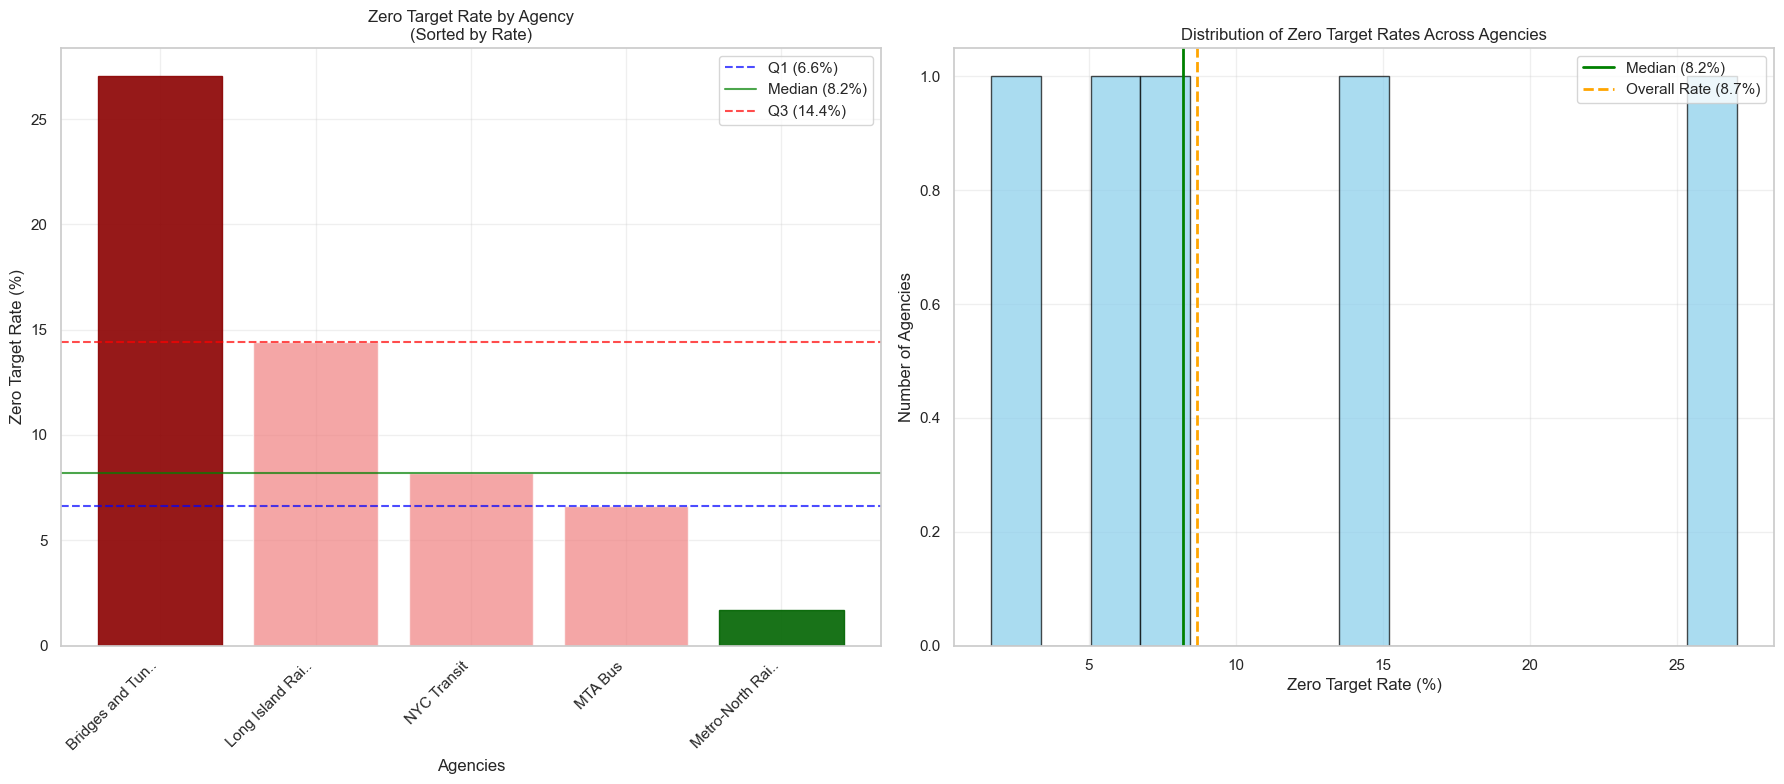


💡 KEY INSIGHTS:
• Range of zero rates: 1.69% to 27.03%
• Coefficient of variation: 84.1%
• High variability in zero target practices across agencies

🎯 RECOMMENDATIONS:
• Document zero-target policies for each agency
• Consider agency-specific imputation methods
• Include 'agency zero-rate' as a model feature
• Investigate business reasons for high zero-rate agencies
• Priority agencies for investigation: 1
  - Bridges and Tunnels: 27.03%


In [182]:
# VISUALIZATION: Zero Target Rates by Agency
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Bar chart of zero target rates by agency
agencies = agency_zero_rates.index
zero_rates = agency_zero_rates['Zero_Rate_Pct']

bars = ax1.bar(range(len(agencies)), zero_rates, color='lightcoral', alpha=0.7)
ax1.set_xlabel('Agencies')
ax1.set_ylabel('Zero Target Rate (%)')
ax1.set_title('Zero Target Rate by Agency\n(Sorted by Rate)')
ax1.set_xticks(range(len(agencies)))
ax1.set_xticklabels([agency[:15] + '..' if len(agency) > 17 else agency for agency in agencies], 
                   rotation=45, ha='right')

# Add horizontal lines for quartiles
ax1.axhline(y=q1, color='blue', linestyle='--', alpha=0.7, label=f'Q1 ({q1:.1f}%)')
ax1.axhline(y=median_rate, color='green', linestyle='-', alpha=0.7, label=f'Median ({median_rate:.1f}%)')
ax1.axhline(y=q3, color='red', linestyle='--', alpha=0.7, label=f'Q3 ({q3:.1f}%)')

# Highlight extreme agencies
for i, (agency, rate) in enumerate(zip(agencies, zero_rates)):
    if rate > q3:
        bars[i].set_color('darkred')
        bars[i].set_alpha(0.9)
    elif rate < q1:
        bars[i].set_color('darkgreen')
        bars[i].set_alpha(0.9)

ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of zero target rates
ax2.hist(zero_rates, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
ax2.axvline(median_rate, color='green', linestyle='-', linewidth=2, label=f'Median ({median_rate:.1f}%)')
ax2.axvline(overall_zero_rate, color='orange', linestyle='--', linewidth=2, label=f'Overall Rate ({overall_zero_rate:.1f}%)')
ax2.set_xlabel('Zero Target Rate (%)')
ax2.set_ylabel('Number of Agencies')
ax2.set_title('Distribution of Zero Target Rates Across Agencies')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary insights
print(f"\n💡 KEY INSIGHTS:")
print(f"• Range of zero rates: {zero_rates.min():.2f}% to {zero_rates.max():.2f}%")
print(f"• Coefficient of variation: {(zero_rates.std() / zero_rates.mean()) * 100:.1f}%")

if zero_rates.std() > 5:  # If standard deviation > 5%
    print(f"• High variability in zero target practices across agencies")
else:
    print(f"• Relatively consistent zero target practices across agencies")

# Practical recommendations
if p < 0.05:
    print(f"\n🎯 RECOMMENDATIONS:")
    print(f"• Document zero-target policies for each agency")
    print(f"• Consider agency-specific imputation methods")
    print(f"• Include 'agency zero-rate' as a model feature")
    print(f"• Investigate business reasons for high zero-rate agencies")
    
    # Identify most problematic agencies
    extreme_agencies = agency_zero_rates[
        (agency_zero_rates['Zero_Rate_Pct'] > q3 + 1.5*(q3-q1)) |  # Outliers above
        (agency_zero_rates['Zero_Rate_Pct'] < q1 - 1.5*(q3-q1))    # Outliers below
    ]
    
    if len(extreme_agencies) > 0:
        print(f"• Priority agencies for investigation: {len(extreme_agencies)}")
        for agency in extreme_agencies.index:
            rate = extreme_agencies.loc[agency, 'Zero_Rate_Pct']
            agency_short = agency[:25] + '..' if len(agency) > 27 else agency
            print(f"  - {agency_short}: {rate:.2f}%")

## Hypothesis 4: Large-scale KPIs are right-skewed, and log1p transformation significantly reduces this skewness.

In [183]:
# H4: Paired Wilcoxon test comparing skewness before vs after log1p transformation
from scipy.stats import skew, wilcoxon

print("=== SKEWNESS REDUCTION ANALYSIS ===\n")

# Filter for valid data (non-negative values for log transformation)
mask = df["MONTHLY_ACTUAL"] > -1
valid_data = df[mask].copy()

print(f"📊 DATA PREPARATION:")
print(f"• Total records: {len(df):,}")
print(f"• Valid records for log transformation: {len(valid_data):,}")
print(f"• Excluded records (negative values): {len(df) - len(valid_data):,}")

# Group by agency-indicator combinations and calculate skewness
g = valid_data.groupby(["AGENCY_NAME", "INDICATOR_NAME"])

# Calculate raw skewness
skew_raw = g["MONTHLY_ACTUAL"].apply(lambda s: skew(s.dropna()) if len(s.dropna()) > 2 else np.nan)

# Calculate log-transformed skewness
skew_log = g["MONTHLY_ACTUAL"].apply(lambda s: skew(np.log1p(s.dropna())) if len(s.dropna()) > 2 else np.nan)

# Combine into paired dataframe
paired = pd.concat([skew_raw, skew_log], axis=1, keys=["raw", "log"])
paired = paired[(paired["raw"].notna()) & (paired["log"].notna())]

print(f"• Series with valid skewness calculations: {len(paired):,}")

# Filter for large-scale KPIs (max > 1000 as suggested, but let's also show different thresholds)
print(f"\n📈 LARGE-SCALE KPI IDENTIFICATION:")

# Calculate maximum values per series to identify large-scale KPIs
max_values = valid_data.groupby(["AGENCY_NAME", "INDICATOR_NAME"])["MONTHLY_ACTUAL"].max()

# Different thresholds for analysis
thresholds = [100, 500, 1000, 5000]
for threshold in thresholds:
    large_scale_series = max_values[max_values > threshold]
    large_scale_count = len(large_scale_series)
    large_scale_pct = (large_scale_count / len(max_values)) * 100 if len(max_values) > 0 else 0
    print(f"• Series with max > {threshold:,}: {large_scale_count} ({large_scale_pct:.1f}%)")

# Focus on the 1000 threshold as specified
threshold = 1000
large_scale_mask = max_values > threshold
large_scale_indices = max_values[large_scale_mask].index

# Filter paired skewness data for large-scale KPIs only
paired_large_scale = paired.loc[large_scale_indices]

print(f"\n🎯 ANALYSIS FOCUS:")
print(f"• Threshold for 'large-scale': max > {threshold:,}")
print(f"• Large-scale series for analysis: {len(paired_large_scale):,}")

if len(paired_large_scale) < 5:
    print(f"⚠️  Too few large-scale series for robust analysis. Expanding to max > 100:")
    threshold = 100
    large_scale_mask = max_values > threshold
    large_scale_indices = max_values[large_scale_mask].index
    paired_large_scale = paired.loc[large_scale_indices]
    print(f"• Expanded analysis series: {len(paired_large_scale):,}")

=== SKEWNESS REDUCTION ANALYSIS ===

📊 DATA PREPARATION:
• Total records: 13,862
• Valid records for log transformation: 13,862
• Excluded records (negative values): 0
• Series with valid skewness calculations: 133

📈 LARGE-SCALE KPI IDENTIFICATION:
• Series with max > 100: 15 (11.3%)
• Series with max > 500: 15 (11.3%)
• Series with max > 1,000: 15 (11.3%)
• Series with max > 5,000: 15 (11.3%)

🎯 ANALYSIS FOCUS:
• Threshold for 'large-scale': max > 1,000
• Large-scale series for analysis: 15


In [184]:
# SKEWNESS STATISTICS AND WILCOXON TEST
print(f"\n📊 SKEWNESS STATISTICS (Large-Scale KPIs):")

if len(paired_large_scale) > 0:
    # Calculate absolute skewness for comparison
    abs_skew_raw = paired_large_scale["raw"].abs()
    abs_skew_log = paired_large_scale["log"].abs()
    
    print(f"Raw Skewness (absolute):")
    print(f"• Mean: {abs_skew_raw.mean():.3f}")
    print(f"• Median: {abs_skew_raw.median():.3f}")
    print(f"• Std: {abs_skew_raw.std():.3f}")
    print(f"• Range: {abs_skew_raw.min():.3f} to {abs_skew_raw.max():.3f}")
    
    print(f"\nLog-Transformed Skewness (absolute):")
    print(f"• Mean: {abs_skew_log.mean():.3f}")
    print(f"• Median: {abs_skew_log.median():.3f}")
    print(f"• Std: {abs_skew_log.std():.3f}")
    print(f"• Range: {abs_skew_log.min():.3f} to {abs_skew_log.max():.3f}")
    
    # Calculate improvement metrics
    improvement = abs_skew_raw - abs_skew_log
    improved_series = (improvement > 0).sum()
    worsened_series = (improvement < 0).sum()
    unchanged_series = (improvement == 0).sum()
    
    print(f"\nIMPROVEMENT SUMMARY:")
    print(f"• Series with reduced skewness: {improved_series} ({improved_series/len(paired_large_scale)*100:.1f}%)")
    print(f"• Series with increased skewness: {worsened_series} ({worsened_series/len(paired_large_scale)*100:.1f}%)")
    print(f"• Series with unchanged skewness: {unchanged_series} ({unchanged_series/len(paired_large_scale)*100:.1f}%)")
    print(f"• Mean absolute improvement: {improvement.mean():.3f}")
    print(f"• Median absolute improvement: {improvement.median():.3f}")
    
    # Perform paired Wilcoxon signed-rank test
    if len(paired_large_scale) >= 6:  # Minimum sample size for Wilcoxon test
        print(f"\n🧪 PAIRED WILCOXON SIGNED-RANK TEST:")
        try:
            # Test if log transformation significantly reduces absolute skewness
            statistic, p_value = wilcoxon(abs_skew_raw, abs_skew_log, alternative='greater')
            
            print(f"• Test statistic: {statistic}")
            print(f"• p-value: {p_value:.6f}")
            print(f"• Sample size: {len(paired_large_scale)}")
            
            # Interpretation
            alpha = 0.05
            if p_value < alpha:
                print(f"✅ SIGNIFICANT RESULT (p < {alpha})")
                print(f"• Log1p transformation significantly reduces skewness")
                print(f"• Justifies keeping log-transformed features for large-scale KPIs")
                
                # Effect size (Cohen's d equivalent for Wilcoxon)
                z_score = abs(statistic - (len(paired_large_scale) * (len(paired_large_scale) + 1) / 4)) / \
                         np.sqrt(len(paired_large_scale) * (len(paired_large_scale) + 1) * (2 * len(paired_large_scale) + 1) / 24)
                effect_size = z_score / np.sqrt(len(paired_large_scale))
                print(f"• Effect size: {effect_size:.3f}")
                
                if effect_size > 0.8:
                    print(f"  → Large effect size: Strong practical significance")
                elif effect_size > 0.5:
                    print(f"  → Medium effect size: Moderate practical significance")
                else:
                    print(f"  → Small effect size: Weak but detectable effect")
                    
            else:
                print(f"❌ NON-SIGNIFICANT RESULT (p ≥ {alpha})")
                print(f"• No significant evidence that log1p reduces skewness")
                print(f"• May not justify log transformation for these KPIs")
        
        except Exception as e:
            print(f"⚠️  Wilcoxon test failed: {e}")
    else:
        print(f"\n⚠️  INSUFFICIENT DATA:")
        print(f"• Need at least 6 series for Wilcoxon test")
        print(f"• Current sample: {len(paired_large_scale)} series")
else:
    print(f"❌ NO LARGE-SCALE KPIS FOUND")
    print(f"• No series meet the threshold criteria")


📊 SKEWNESS STATISTICS (Large-Scale KPIs):
Raw Skewness (absolute):
• Mean: 1.163
• Median: 0.426
• Std: 2.596
• Range: 0.020 to 10.438

Log-Transformed Skewness (absolute):
• Mean: 1.003
• Median: 0.255
• Std: 2.391
• Range: 0.003 to 9.566

IMPROVEMENT SUMMARY:
• Series with reduced skewness: 8 (53.3%)
• Series with increased skewness: 7 (46.7%)
• Series with unchanged skewness: 0 (0.0%)
• Mean absolute improvement: 0.160
• Median absolute improvement: 0.160

🧪 PAIRED WILCOXON SIGNED-RANK TEST:
• Test statistic: 76.0
• p-value: 0.194702
• Sample size: 15
❌ NON-SIGNIFICANT RESULT (p ≥ 0.05)
• No significant evidence that log1p reduces skewness
• May not justify log transformation for these KPIs


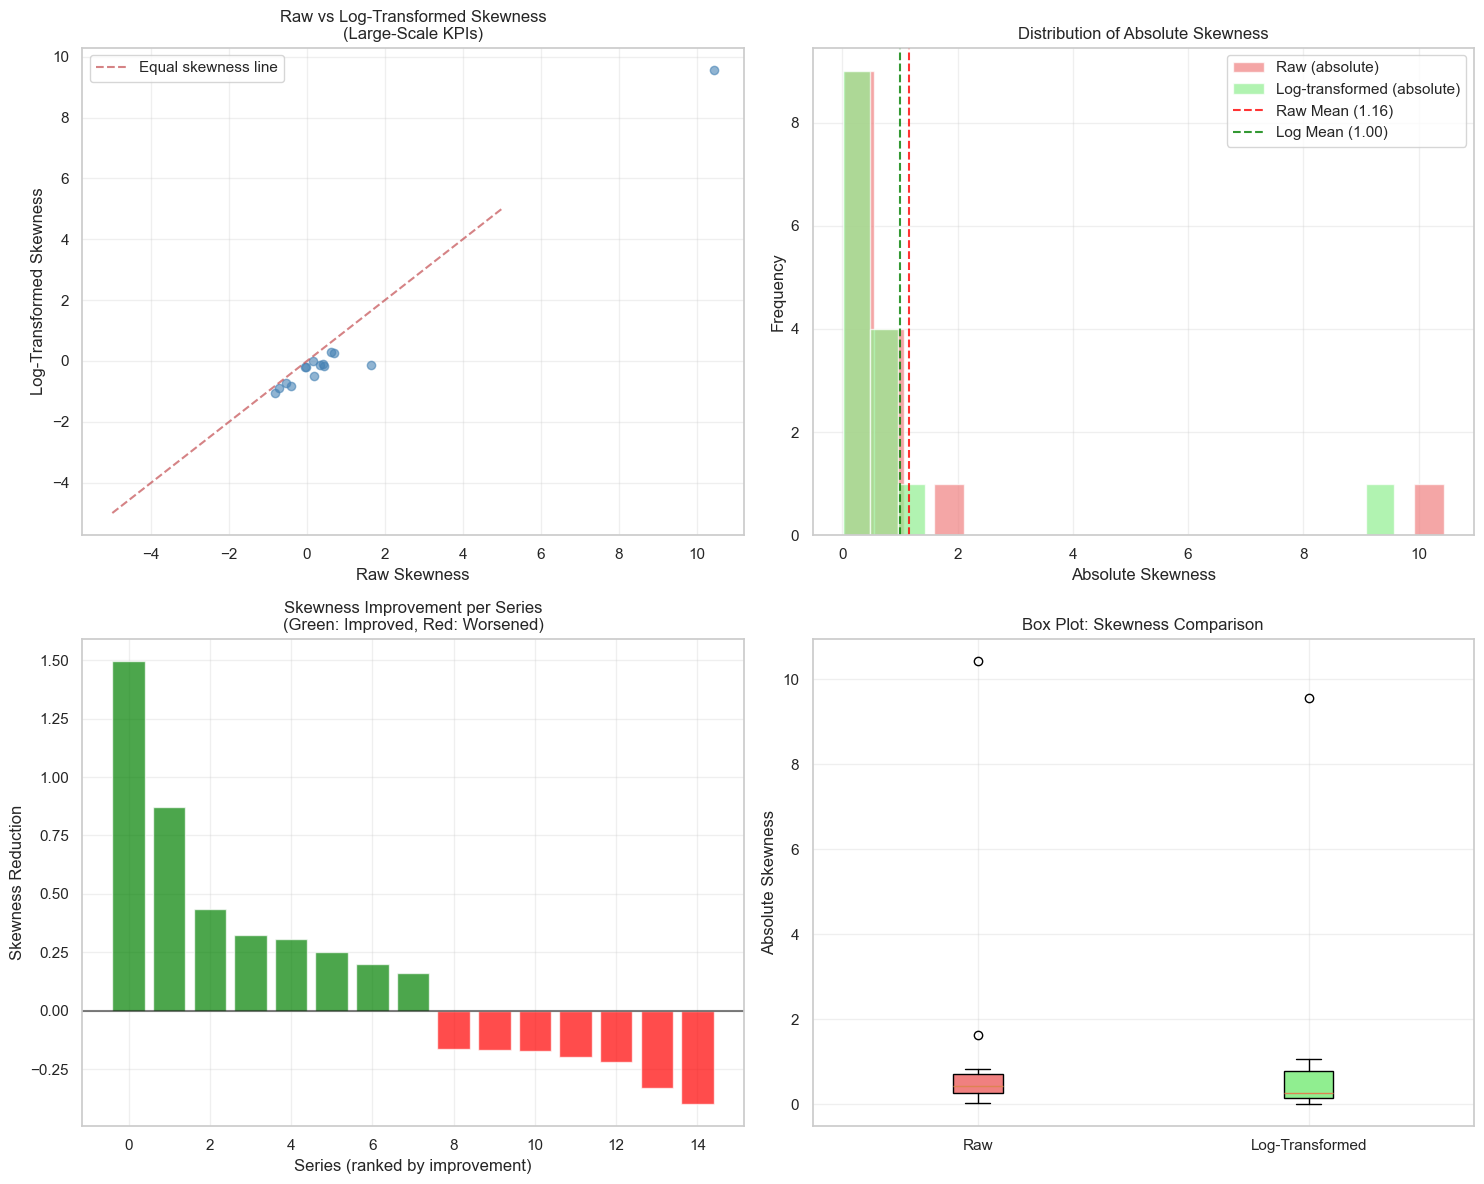


🏆 TOP 5 MOST IMPROVED SERIES:
• Metro-North Railroad | Mean Distance Between Fai..
  Raw skewness: 1.628 → Log skewness: -0.131 (Δ: 1.497)
• NYC Transit | Total Paratransit Ridersh..
  Raw skewness: 10.438 → Log skewness: 9.566 (Δ: 0.872)
• NYC Transit | Mean Distance Between Fai..
  Raw skewness: 0.689 → Log skewness: 0.255 (Δ: 0.434)
• NYC Transit | Mean Distance Between Fai..
  Raw skewness: 0.615 → Log skewness: 0.288 (Δ: 0.326)
• MTA Bus | Bus Passenger Wheelchair ..
  Raw skewness: 0.409 → Log skewness: -0.102 (Δ: 0.307)

📉 TOP 5 MOST WORSENED SERIES:
• MTA Bus | Total Ridership - MTA Bus 
  Raw skewness: -0.043 → Log skewness: -0.214 (Δ: -0.170)
• Long Island Rail Road | Total Ridership
  Raw skewness: -0.539 → Log skewness: -0.739 (Δ: -0.200)
• Bridges and Tunnels | Total Traffic
  Raw skewness: -0.835 → Log skewness: -1.052 (Δ: -0.217)
• NYC Transit | Mean Distance Between Fai..
  Raw skewness: 0.176 → Log skewness: -0.508 (Δ: -0.332)
• NYC Transit |  Bus Passenger Wheelchair

In [185]:
# VISUALIZATION: Skewness Comparison
if len(paired_large_scale) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Scatter plot of raw vs log skewness
    ax1 = axes[0, 0]
    ax1.scatter(paired_large_scale["raw"], paired_large_scale["log"], alpha=0.6, color='steelblue')
    ax1.plot([-5, 5], [-5, 5], 'r--', alpha=0.7, label='Equal skewness line')
    ax1.set_xlabel('Raw Skewness')
    ax1.set_ylabel('Log-Transformed Skewness')
    ax1.set_title('Raw vs Log-Transformed Skewness\n(Large-Scale KPIs)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of absolute skewness
    ax2 = axes[0, 1]
    ax2.hist(abs_skew_raw, bins=20, alpha=0.7, label='Raw (absolute)', color='lightcoral')
    ax2.hist(abs_skew_log, bins=20, alpha=0.7, label='Log-transformed (absolute)', color='lightgreen')
    ax2.axvline(abs_skew_raw.mean(), color='red', linestyle='--', alpha=0.8, label=f'Raw Mean ({abs_skew_raw.mean():.2f})')
    ax2.axvline(abs_skew_log.mean(), color='green', linestyle='--', alpha=0.8, label=f'Log Mean ({abs_skew_log.mean():.2f})')
    ax2.set_xlabel('Absolute Skewness')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Absolute Skewness')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Improvement per series
    ax3 = axes[1, 0]
    improvement_sorted = improvement.sort_values(ascending=False)
    bars = ax3.bar(range(len(improvement_sorted)), improvement_sorted, 
                   color=['green' if x > 0 else 'red' for x in improvement_sorted], alpha=0.7)
    ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax3.set_xlabel('Series (ranked by improvement)')
    ax3.set_ylabel('Skewness Reduction')
    ax3.set_title('Skewness Improvement per Series\n(Green: Improved, Red: Worsened)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Box plot comparison
    ax4 = axes[1, 1]
    box_data = [abs_skew_raw, abs_skew_log]
    bp = ax4.boxplot(box_data, labels=['Raw', 'Log-Transformed'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightgreen')
    ax4.set_ylabel('Absolute Skewness')
    ax4.set_title('Box Plot: Skewness Comparison')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show examples of most improved series
    print(f"\n🏆 TOP 5 MOST IMPROVED SERIES:")
    top_improved = improvement_sorted.head(5)
    for (agency, indicator), improvement_val in top_improved.items():
        agency_short = agency[:20] + '..' if len(agency) > 22 else agency
        indicator_short = indicator[:25] + '..' if len(indicator) > 27 else indicator
        raw_skew = paired_large_scale.loc[(agency, indicator), "raw"]
        log_skew = paired_large_scale.loc[(agency, indicator), "log"]
        print(f"• {agency_short} | {indicator_short}")
        print(f"  Raw skewness: {raw_skew:.3f} → Log skewness: {log_skew:.3f} (Δ: {improvement_val:.3f})")
    
    # Show examples of most worsened series
    print(f"\n📉 TOP 5 MOST WORSENED SERIES:")
    top_worsened = improvement_sorted.tail(5)
    for (agency, indicator), improvement_val in top_worsened.items():
        agency_short = agency[:20] + '..' if len(agency) > 22 else agency
        indicator_short = indicator[:25] + '..' if len(indicator) > 27 else indicator
        raw_skew = paired_large_scale.loc[(agency, indicator), "raw"]
        log_skew = paired_large_scale.loc[(agency, indicator), "log"]
        print(f"• {agency_short} | {indicator_short}")
        print(f"  Raw skewness: {raw_skew:.3f} → Log skewness: {log_skew:.3f} (Δ: {improvement_val:.3f})")
